# Группа DE_622, Студент: Виталий Зайцев

## Курс "Построение хранилища данных и основы ETL", Урок 7. Управление качеством данных

Домашнее задание по уроку 7:   
1) Написать оператор для сбора статистики в таблицу statistic. Метод записи из utils.py: def write_etl_statistic().   
2) Создать отдельный даг с этим оператором. Перед сбором статистики должен быть external_task_sensor на успешное выполнение переливки данных.

---

# Выполнение домашнего задания

__Общий подход:__  
НЕ используем Great Expectation (and SqlAlchemy), создаём custom БД метаданных и модицируем структуры данных-даги для использования custom БД метаданных


__Действия:__   
1.Обновить схемы данных:   
1.1.Добавить новые столбцы   
1.2.Создать новые таблицы    
   
2.Заполнить данными таблицы-источники   
   
3.Модифицировать ранее созданные DAG'и и объединить частные DAG'и импорта для каждой таблицы (8 частных DAGs) в один объединённый DAG (импорт всех 8-ми таблиц)   
3.1.+модуль units   
3.2.+модуль statistics   
3.3.изменения в data_transfer   
3.4.изменения в postgres   
   
4.Создать новый DAG обработки статистики (в качестве sensorа указать объединённый DAG импорта)  

## Подготовительные действия (пакеты, схемы данных и загрузка данных)

__Внимание: Работаем в Win10__

### Обновить используемые пакеты:   
`
pip install --upgrade psycopg2-binary pandas apache-airflow
`

### docker-compose.yml (прежний, из урока 6, без изменений)

`
version: "3"
services:
  db1:
    image: "postgres:11"
    container_name: "my_postgres_1"
    ports:
      - "5433:5432"
    volumes:
      - my_dbdata:/var/lib/postgresql/data1
    environment:
      - POSTGRES_PASSWORD=postgres
      - POSTGRES_USER=root
  db2:
    image: "postgres:11"
    container_name: "my_postgres_2"
    ports:
      - "54320:5432"
    volumes:
      - my_dbdata:/var/lib/postgresql/data2
    environment:
      - POSTGRES_PASSWORD=postgres
      - POSTGRES_USER=root
  airflow:
    image: puckel/docker-airflow
    container_name: "airflow"
    ports:
      - "8080:8080"
    environment:
      - PYTHONPATH=/usr/local/airflow/dags/operators/
    volumes:
      - ./dags:/usr/local/airflow/dags
    command: webserver
volumes:
  my_dbdata:   
 `

### Запуск докера, создание таблиц и наполнение данными 

* copypast docker-compose.yml в папку папку размещения airflow /usr/local/airflow/   

* переход в папку размещения airflow /usr/local/airflow/ (в моём случае Win10 и папка ниже)   
`cd C:\Users\vzaitsev\airflow
`   
   
* запуск докера   
`docker-compose up -d   
`

* создание баз данных (база-source, база-target)     
`
docker exec -it my_postgres_1 psql -U root -c "create database my_database_1"   
docker exec -it my_postgres_2 psql -U root -c "create database my_database_2"
`
* создание таблиц  (база-source, база-target)    
`
cd C:\Users\vzaitsev\!Git-REPO\tpch-kit\dbgen\
docker cp ./dss.ddl my_postgres_1:/
docker cp ./dss.ddl my_postgres_2:/
docker exec -it my_postgres_1 psql my_database_1 -f dss.ddl
docker exec -it my_postgres_2 psql my_database_2 -f dss.ddl
`
* синтез данных (попытка генерации таблиц под Win10 была неуспешна, используем ранее полученные таблицы от преподавателя)   
`
customer.tbl   
lineitem.tbl   
nation.tbl   
orders.tbl   
part.tbl   
partsupp.tbl   
region.tbl   
supplier.tbl     
`

* копирование данных для таблиц в контейнер   
`
cd C:\Generated tables
docker cp ./customer.tbl my_postgres_1:/
docker cp ./lineitem.tbl my_postgres_1:/
docker cp ./nation.tbl my_postgres_1:/
docker cp ./orders.tbl my_postgres_1:/
docker cp ./part.tbl my_postgres_1:/
docker cp ./partsupp.tbl my_postgres_1:/
docker cp ./region.tbl my_postgres_1:/
docker cp ./supplier.tbl my_postgres_1:/
`
* загрузка данных в базу-__source__    
`
docker exec -it my_postgres_1 psql my_database_1 -c "\copy customer FROM '/customer.tbl' CSV DELIMITER '|'"
docker exec -it my_postgres_1 psql my_database_1 -c "\copy lineitem FROM '/lineitem.tbl' CSV DELIMITER '|'"
docker exec -it my_postgres_1 psql my_database_1 -c "\copy nation FROM '/nation.tbl' CSV DELIMITER '|'"
docker exec -it my_postgres_1 psql my_database_1 -c "\copy orders FROM '/orders.tbl' CSV DELIMITER '|'"
docker exec -it my_postgres_1 psql my_database_1 -c "\copy part FROM '/part.tbl' CSV DELIMITER '|'"
docker exec -it my_postgres_1 psql my_database_1 -c "\copy partsupp FROM '/partsupp.tbl' CSV DELIMITER '|'"
docker exec -it my_postgres_1 psql my_database_1 -c "\copy region FROM '/region.tbl' CSV DELIMITER '|'"
docker exec -it my_postgres_1 psql my_database_1 -c "\copy supplier FROM '/supplier.tbl' CSV DELIMITER '|'"
`

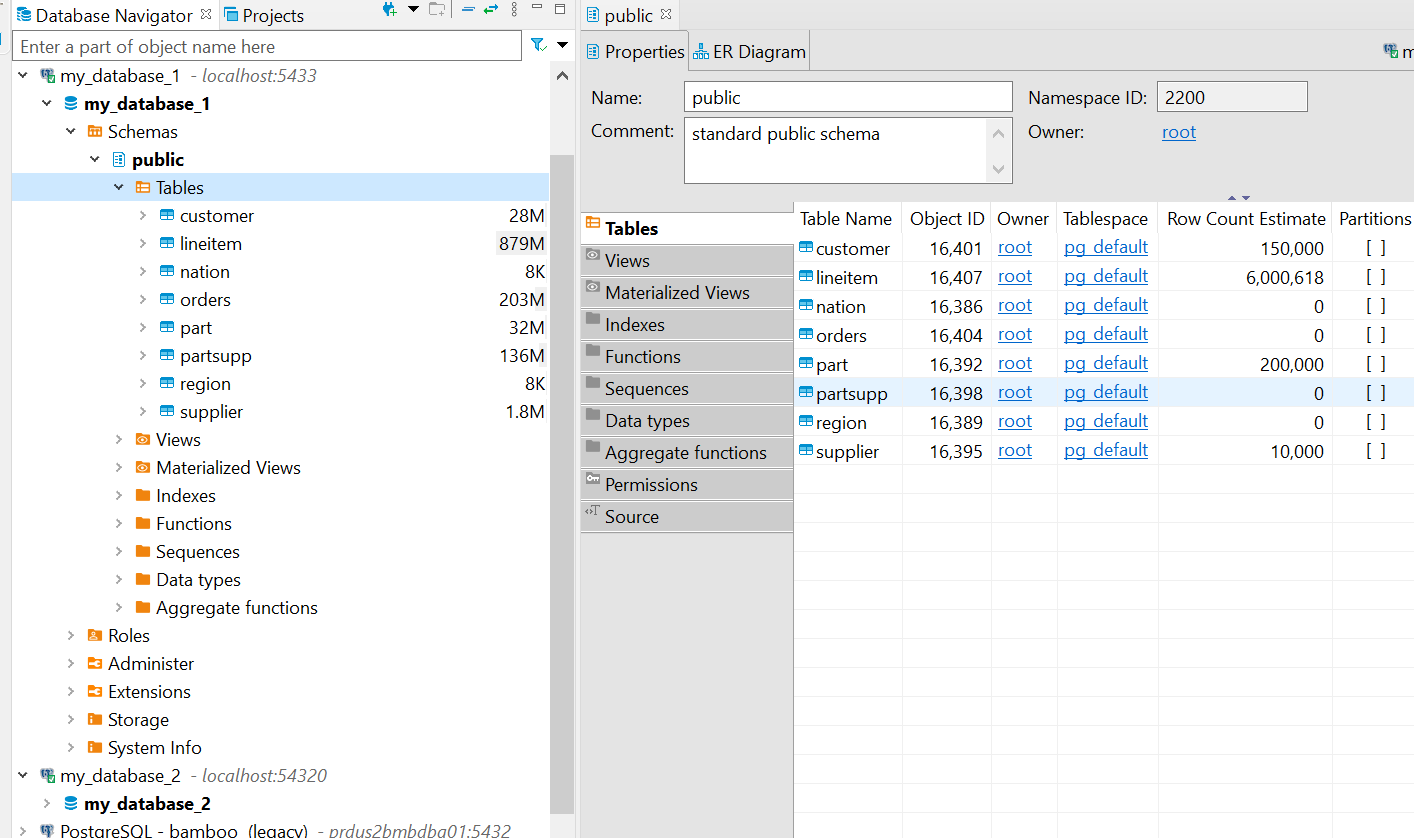

* модицикация таблиц базы-__target__: добавление полей   
`
• launch_id (уникальный идентификатор таска)
• effective_dttm (дата загрузки, default now())
`
   
`
docker exec -it my_postgres_2 psql my_database_2 -c "ALTER TABLE customer ADD COLUMN launch_id int;"
docker exec -it my_postgres_2 psql my_database_2 -c "ALTER TABLE customer ADD COLUMN effective_dttm date DEFAULT now();"
docker exec -it my_postgres_2 psql my_database_2 -c "ALTER TABLE lineitem ADD COLUMN launch_id int;"
docker exec -it my_postgres_2 psql my_database_2 -c "ALTER TABLE lineitem ADD COLUMN effective_dttm date DEFAULT now();"
docker exec -it my_postgres_2 psql my_database_2 -c "ALTER TABLE nation ADD COLUMN launch_id int;"
docker exec -it my_postgres_2 psql my_database_2 -c "ALTER TABLE nation ADD COLUMN effective_dttm date DEFAULT now();"
docker exec -it my_postgres_2 psql my_database_2 -c "ALTER TABLE orders ADD COLUMN launch_id int;"
docker exec -it my_postgres_2 psql my_database_2 -c "ALTER TABLE orders ADD COLUMN effective_dttm date DEFAULT now();"
docker exec -it my_postgres_2 psql my_database_2 -c "ALTER TABLE part ADD COLUMN launch_id int;"
docker exec -it my_postgres_2 psql my_database_2 -c "ALTER TABLE part ADD COLUMN effective_dttm date DEFAULT now();"
docker exec -it my_postgres_2 psql my_database_2 -c "ALTER TABLE partsupp ADD COLUMN launch_id int;"
docker exec -it my_postgres_2 psql my_database_2 -c "ALTER TABLE partsupp ADD COLUMN effective_dttm date DEFAULT now();"
docker exec -it my_postgres_2 psql my_database_2 -c "ALTER TABLE region ADD COLUMN launch_id int;"
docker exec -it my_postgres_2 psql my_database_2 -c "ALTER TABLE region ADD COLUMN effective_dttm date DEFAULT now();"
docker exec -it my_postgres_2 psql my_database_2 -c "ALTER TABLE supplier ADD COLUMN launch_id int;"
docker exec -it my_postgres_2 psql my_database_2 -c "ALTER TABLE supplier ADD COLUMN effective_dttm date DEFAULT now();"
`

* создание базы метаданных (в нашем случае +2 таблицы (таблица логов и таблица статистики) в базе-target)   
`
docker exec -it my_postgres_2 psql my_database_2 -c "create table statistic (table_name text, column_name text, cnt_nulls      int, cnt_all int, load_date date);"
docker exec -it my_postgres_2 psql my_database_2 -c "create table log (source_launch_id int, target_schema text, target_table text, target_launch_id int, processed_dttm  timestamp default now(), row_count int, duration interval, load_date date);"
`


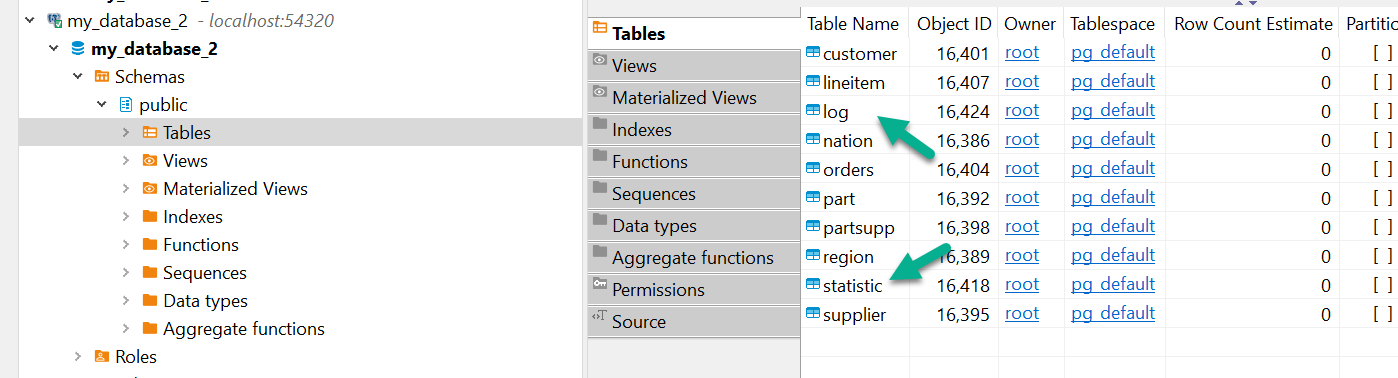

## Модули и DAG'и

### Модифицированный operators/postgres.py (+ запись task_instance)

In [ ]:
from operators.data_transfer import DataTransfer
import csv
import psycopg2


class DataTransferPostgres(DataTransfer):
    def __init__(
        self, source_pg_conn_str, query, *args, **kwargs
    ):
        super(DataTransferPostgres, self).__init__(
            source_pg_conn_str=source_pg_conn_str, query=query, *args, **kwargs
        )
        self.source_pg_conn_str = source_pg_conn_str
        self.query = query

    def provide_data(self, csv_file, context):
        pg_conn = psycopg2.connect(self.source_pg_conn_str)
        pg_cursor = pg_conn.cursor()
        query_to_execute = self.query
        self.log.info("Executing query: {}".format(query_to_execute))
        pg_cursor.execute(query_to_execute)
        csvwriter = csv.writer(
            csv_file,
            delimiter="\t",
            quoting=csv.QUOTE_NONE,
            lineterminator="\n",
            escapechar='\\'
        )

        job_id = context["task_instance"].job_id,    # ИЗМЕНЕНИЕ!!!!!!!!
        while True:
            rows = pg_cursor.fetchmany(size=1000)
            if rows:
                for row in rows:
                    _row = list(row)
                    _row.append(job_id[0])           # ИЗМЕНЕНИЕ!!!!!!!!!
                    csvwriter.writerow(_row)
            else:
                break
        pg_conn.close()

### Модифицированный operators/data_transfer.py  (+методы записи логов и проверка загрузки за определенную дату)

In [ ]:
import datetime
import logging
import os
import time
from contextlib import contextmanager

import psycopg2
from airflow.models import BaseOperator
from airflow.utils.decorators import apply_defaults

from operators.utils import DataFlowBaseOperator


class DataTransfer(DataFlowBaseOperator):  # modify
    @apply_defaults
    def __init__(self, config, target_pg_conn_str,  date_check=True, *args, **kwargs):
        super(DataTransfer, self).__init__(
            *args,
            **kwargs
        )
        self.config = config
        self.target_pg_conn_str = target_pg_conn_str
        self.date_check = date_check

    def provide_data(self, csv_file, context):
        pass

    def execute(self, context):
        copy_statement = """
        COPY {target_schema}.{target_table} ({columns}, launch_id) FROM STDIN with
        DELIMITER '\t'
        CSV
        ESCAPE '\\'
        NULL '';
        """
        schema_name = "{table}".format(**self.config).split(".")
        self.config.update(
            target_schema=schema_name[0],
            target_table=schema_name[1],
            job_id=context["task_instance"].job_id,  # modify
            dt=context["task_instance"].execution_date,  # modify
        )
        # ИЗМЕНЕНИЕ!!!!!!!!!
        if self.date_check and context["execution_date"] in self.get_load_dates(
            self.config
        ):
            logging.info("Data has already been uploaded")
            return
        with psycopg2.connect(self.target_pg_conn_str) as conn, conn.cursor() as cursor:
            start = time.time()  # modify
            # modify
            cursor.execute(
                """
            select column_name
              from information_schema.columns
             where table_schema = '{target_schema}'
               and table_name = '{target_table}'
               and column_name not in ('launch_id', 'effective_dttm');
            """.format(
                    **self.config
                )
            )
            result = cursor.fetchall()
            columns = ", ".join('"{}"'.format(row) for row, in result)
            self.config.update(columns=columns)

            with open("./dags/transfer.csv", "w", encoding="utf-8") as csv_file:
                self.provide_data(csv_file, context)

            self.log.info("writing succed")

            with open('./dags/transfer.csv', 'r', encoding="utf-8") as f:
                cursor.copy_expert(copy_statement.format(**self.config), f)

            self.config.update(  # modify
                launch_id=-1,
                duration=datetime.timedelta(seconds=time.time() - start),
                row_count=cursor.rowcount
            )
            self.write_etl_log(self.config)  # modify


### Новый operators/utils.py (методы для сбора статистики, записи логов и проверки статуса загрузки данных)

In [ ]:
import logging
import psycopg2
from airflow.models import BaseOperator


class DataFlowBaseOperator(BaseOperator):
    def __init__(self, pg_meta_conn_str, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pg_meta_conn_str = pg_meta_conn_str

    def write_etl_log(self, config):
        with psycopg2.connect(self.pg_meta_conn_str) as conn, conn.cursor() as cursor:
            query = '''
            insert into log (
                   source_launch_id
                 , target_schema
                 , target_table
                 , target_launch_id
                 , row_count
                 , duration
                 , load_date
            )
            select {launch_id}
                , '{target_schema}'
                , '{target_table}'
                , {job_id}
                , {row_count}
                , '{duration}'
                , '{dt}'
            '''
            cursor.execute(query.format(**config))
            logging.info(
                'Log update: {target_table} : {job_id}'.format(**config))
            conn.commit()

    def write_etl_statistic(self, config):
        with psycopg2.connect(self.pg_meta_conn_str) as conn, conn.cursor() as cursor:
            query = '''
            insert into statistic (
                   table_name
                 , column_name
                 , cnt_nulls
                 , cnt_all
                 , load_date
            )
            with x as (
                select '{table}' as table_name,
                    '{column}' as column_name,
                    {cnt_nulls} as cnt_nulls,
                    {cnt_all} as cnt_all,
                    {job_id} as launch_id
                )
            select table_name,
                column_name,
                cnt_nulls,
                cnt_all,
                '{dt}' as load_date
            from x left join log l
            on x.launch_id = l.target_launch_id
            '''
            cursor.execute(query.format(**config))
            conn.commit()

    def get_load_dates(self, config):
        with psycopg2.connect(self.pg_meta_conn_str) as conn, conn.cursor() as cursor:
            query = '''
            select array_agg(distinct load_date order by load_date)
                from log
                where target_table = '{target_table}'
                and target_schema = '{target_schema}'
                and source_launch_id = -1
            '''
            cursor.execute(query.format(**config))
            dates = cursor.fetchone()[0]
        if dates:
            return dates
        else:
            return []


# Решаем задачу объединения частных DAG'ов в общий, добавим функцию определения перечня таблиц для импорта 
def source_table_list():
    # в этой функции просто захардкодим перечень таблиц для импорта. 8 таблиц - значит, 8 таблиц
    list = ['customer', 'lineitem', 'nation', 'orders', 'part', 'partsupp', 'region', 'supplier']

    return list


### Новый operators/statistics.py (спец класс-оператор для сбора статистики в таблицу statistic)

In [ ]:
import logging
import os
import time
import re
import psycopg2
from airflow.utils.decorators import apply_defaults
from operators.data_transfer import DataTransfer


class WriteStatisticsOperator(DataTransfer):
    @apply_defaults
    def __init__(self, config, target_pg_conn_str, *args, **kwargs):
        super(DataTransfer, self).__init__(
            *args,
            **kwargs
        )
        self.config = config
        self.target_pg_conn_str = target_pg_conn_str

    def execute(self, context):

        schema_name = "{table}".format(**self.config).split(".")
        self.config.update(
            target_schema=schema_name[0],
            target_table=schema_name[1],
            job_id=context["task_instance"].job_id,  # modify
            dt=context["task_instance"].execution_date,  # modify
        )

        with psycopg2.connect(self.target_pg_conn_str) as conn, conn.cursor() as cursor:
            cursor.execute(
                """
            select column_name
              from information_schema.columns
             where table_schema = '{target_schema}'
               and table_name = '{target_table}'
               and column_name not in ('launch_id', 'effective_dttm');
            """.format(
                    **self.config
                )
            )
            result = cursor.fetchall()
            columns = ", ".join('"{}"'.format(row) for row, in result)
            self.config.update(columns=columns)
            column_list = list(columns.split(', '))
            for item in column_list:

                self.config.update(column=item)
                with psycopg2.connect(self.target_pg_conn_str) as conn, conn.cursor() as cursor:
                    cursor.execute(
                        """ select count({column}) from {target_table} where {column} is not null""".format(
                            **self.config)
                    )
                    result = cursor.fetchone()
                    result = re.search(r'\d+', str(result))
                    self.config.update(cnt_all=result[0])
                with psycopg2.connect(self.target_pg_conn_str) as conn, conn.cursor() as cursor:
                    cursor.execute(
                        """ select count({column}) from {target_table} where {column} is null;""".format(
                            **self.config)
                    )
                    result = cursor.fetchone()
                    result = re.search(r'\d+', str(result))
                    self.config.update(cnt_nulls=result[0])

                self.write_etl_statistic(self.config)


### DAG #1 DAG_data_migration.py Миграция данных (8 таблиц)

In [ ]:
from airflow import DAG
from operators.postgres import DataTransferPostgres
from operators.utils import source_table_list
from datetime import datetime

DEFAULT_ARGS = {
    "owner": "airflow",
    "start_date": datetime(2021, 1, 25),
    "retries": 1,
    "email_on_failure": False,
    "email_on_retry": False,
    "depends_on_past": False, # в случае регулярной эксплуатации следует поставить True. Сейчас указал False для целей отладки
}

with DAG(
    dag_id="DataMigration",
    default_args=DEFAULT_ARGS,
    schedule_interval="@daily",
    max_active_runs=1,
    tags=['data-flow'],
) as dag1:
    # это как было - частный DAG
    # сам data flow, для таблицы part
    #data_transfer = DataTransferPostgres(
    #    config={'table': 'public.part'},
    #    query='select * from part',
    #    task_id='part',
    #    source_pg_conn_str="host='host.docker.internal' port=5433 dbname='my_database_1' user='root' password='postgres'",
    #    pg_conn_str="host='host.docker.internal' port=54320 dbname='my_database_2' user='root' password='postgres'",
    #)
    # Порядок выполнения тасок
    #data_transfer

    data_dump = {
        table: DataTransferPostgres(
            config={'table': f'public.{table}'},
            query=f'select * from {table}',
            task_id=f'{table}',
            source_pg_conn_str="host='host.docker.internal' port=5433 dbname='my_database_1' user='root' password='postgres'",
            target_pg_conn_str="host='host.docker.internal' port=54320 dbname='my_database_2' user='root' password='postgres'",
            pg_meta_conn_str="host='host.docker.internal' port=54320 dbname='my_database_2' user='root' password='postgres'"
        )
        for table in source_table_list()
    }


### DAG #2 DAG_sensor_statistics.py Сенсор на миграцию данных и статистика 

In [ ]:
from airflow import DAG
from airflow.sensors.external_task_sensor import ExternalTaskSensor
from operators.statistics import WriteStatisticsOperator
from operators.utils import source_table_list
from datetime import datetime

DEFAULT_ARGS = {
    "owner": "airflow",
    "start_date": datetime(2021, 1, 25),
    "retries": 1,
    "email_on_failure": False,
    "email_on_retry": False,
    "depends_on_past": False, # в случае регулярной эксплуатации следует поставить True. Сейчас указал False для целей отладки
}

with DAG(
    dag_id='SensorStatistics',
    default_args=DEFAULT_ARGS,
    schedule_interval="@daily",
    catchup=True,
    max_active_runs=1,
    tags=['data-flow-statistics'],
) as dag1:
    # sensor = ExternalTaskSensor(
    #     task_id='customer_sensor',
    #     external_dag_id='DataMigration',
    #     external_task_id='customer'
    # )
    # statistics = WriteStatisticsOperator(
    #     task_id='customer_statistics',
    #     config={'table': 'public.customer'},
    #     pg_meta_conn_str="host='host.docker.internal' port=54320 dbname='my_database_2' user='root' password='postgres'",
    #     target_pg_conn_str="host='host.docker.internal' port=54320 dbname='my_database_2' user='root' password='postgres'"
    # )

    for table in source_table_list():
        sensor = ExternalTaskSensor(
            task_id=f'{table}_sensor',
            external_dag_id='DataMigration',
            external_task_id=f'{table}'
        )

        statistics = WriteStatisticsOperator(
            config={'table': f'public.{table}'},
            task_id=f'{table}_statistics',
            pg_meta_conn_str="host='host.docker.internal' port=54320 dbname='my_database_2' user='root' password='postgres'",
            target_pg_conn_str="host='host.docker.internal' port=54320 dbname='my_database_2' user='root' password='postgres'"
        )

        sensor >> statistics


## Airflow http://localhost:8080/admin/ Размещаем подготовленные DAG"и и модули и запускаем (ситуация в динамике)

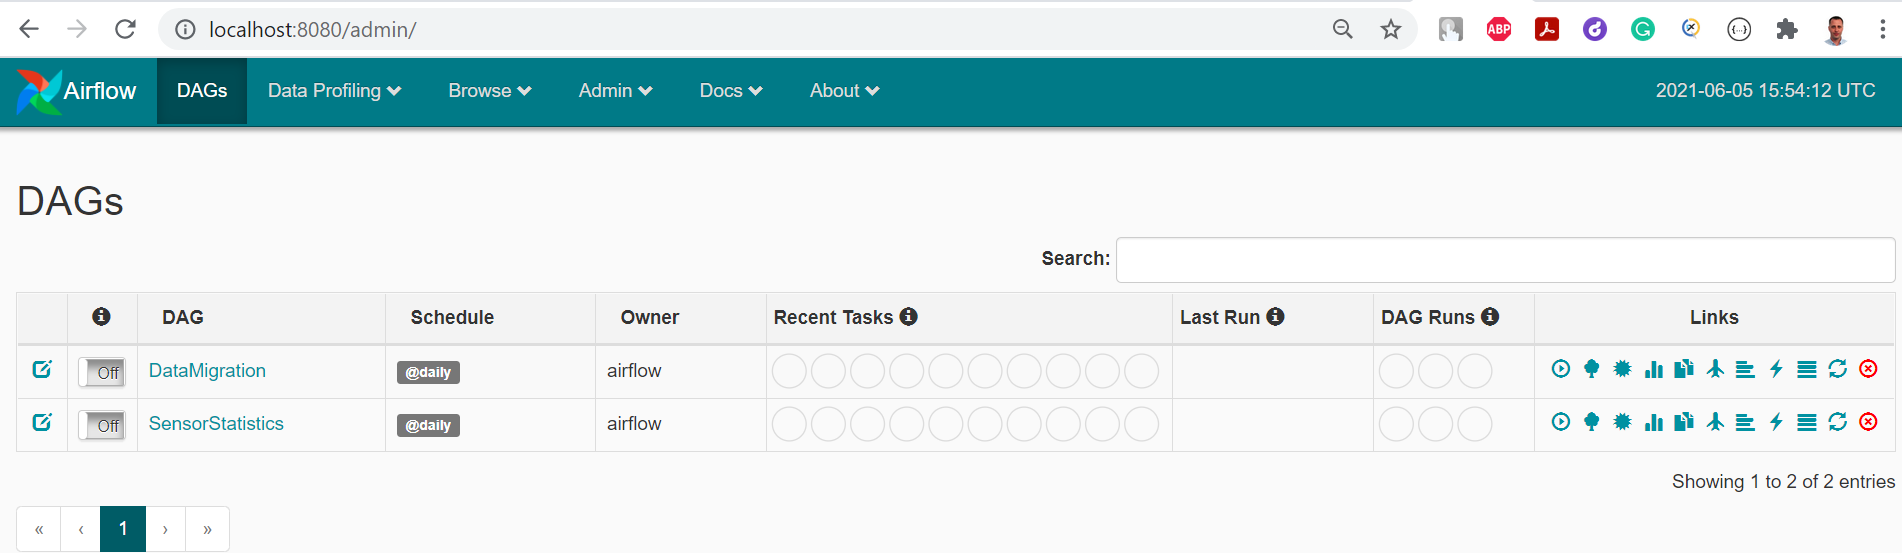

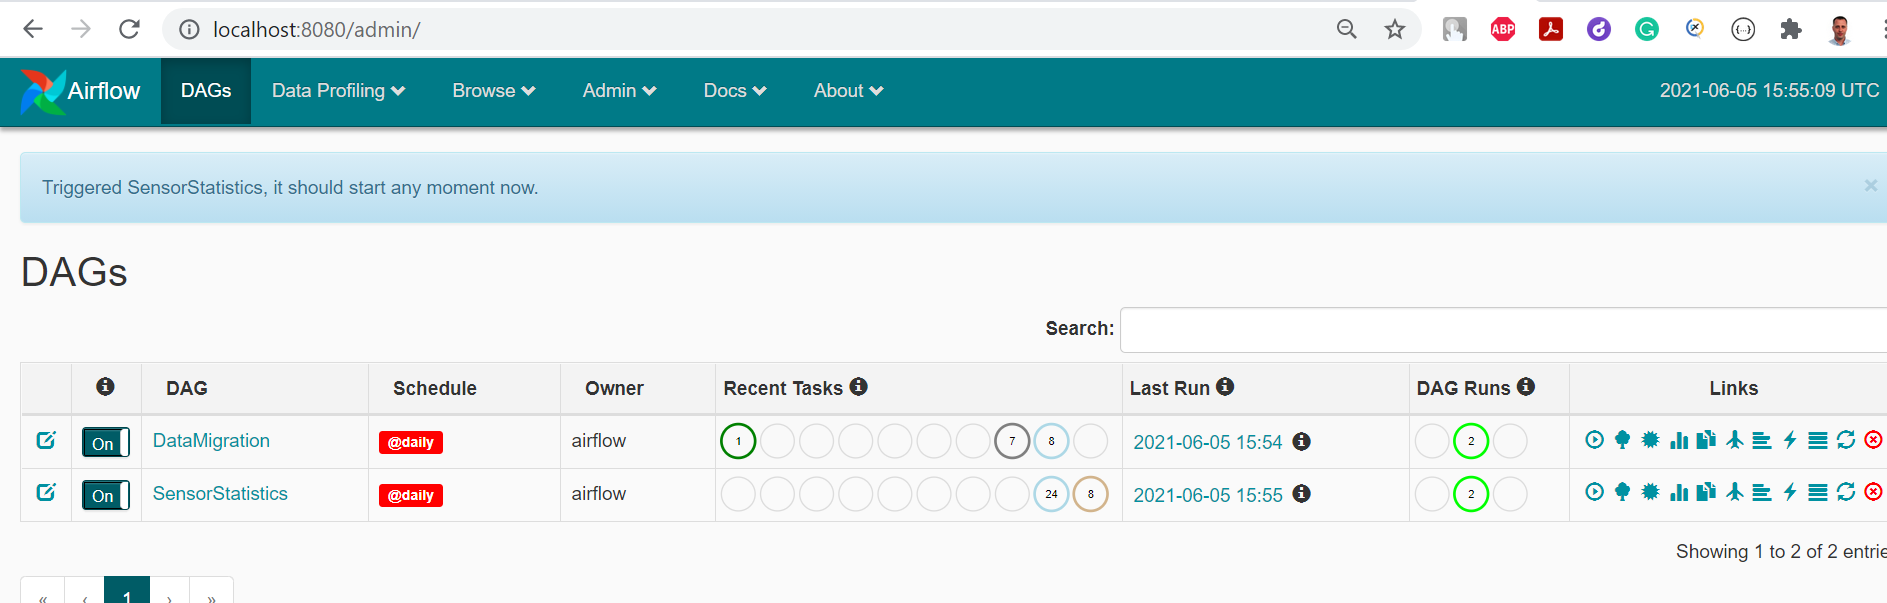

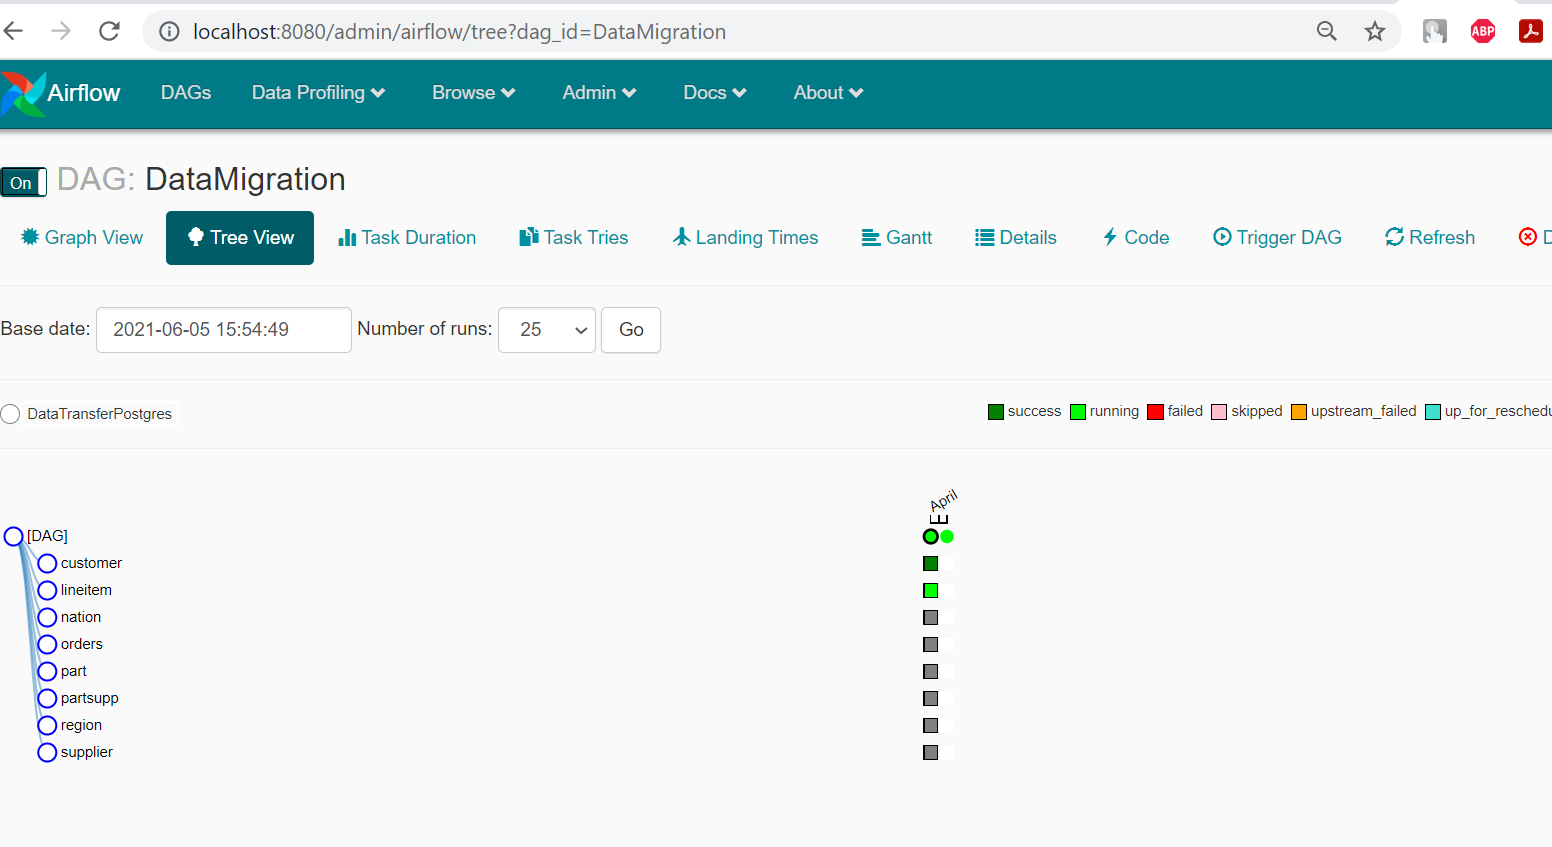

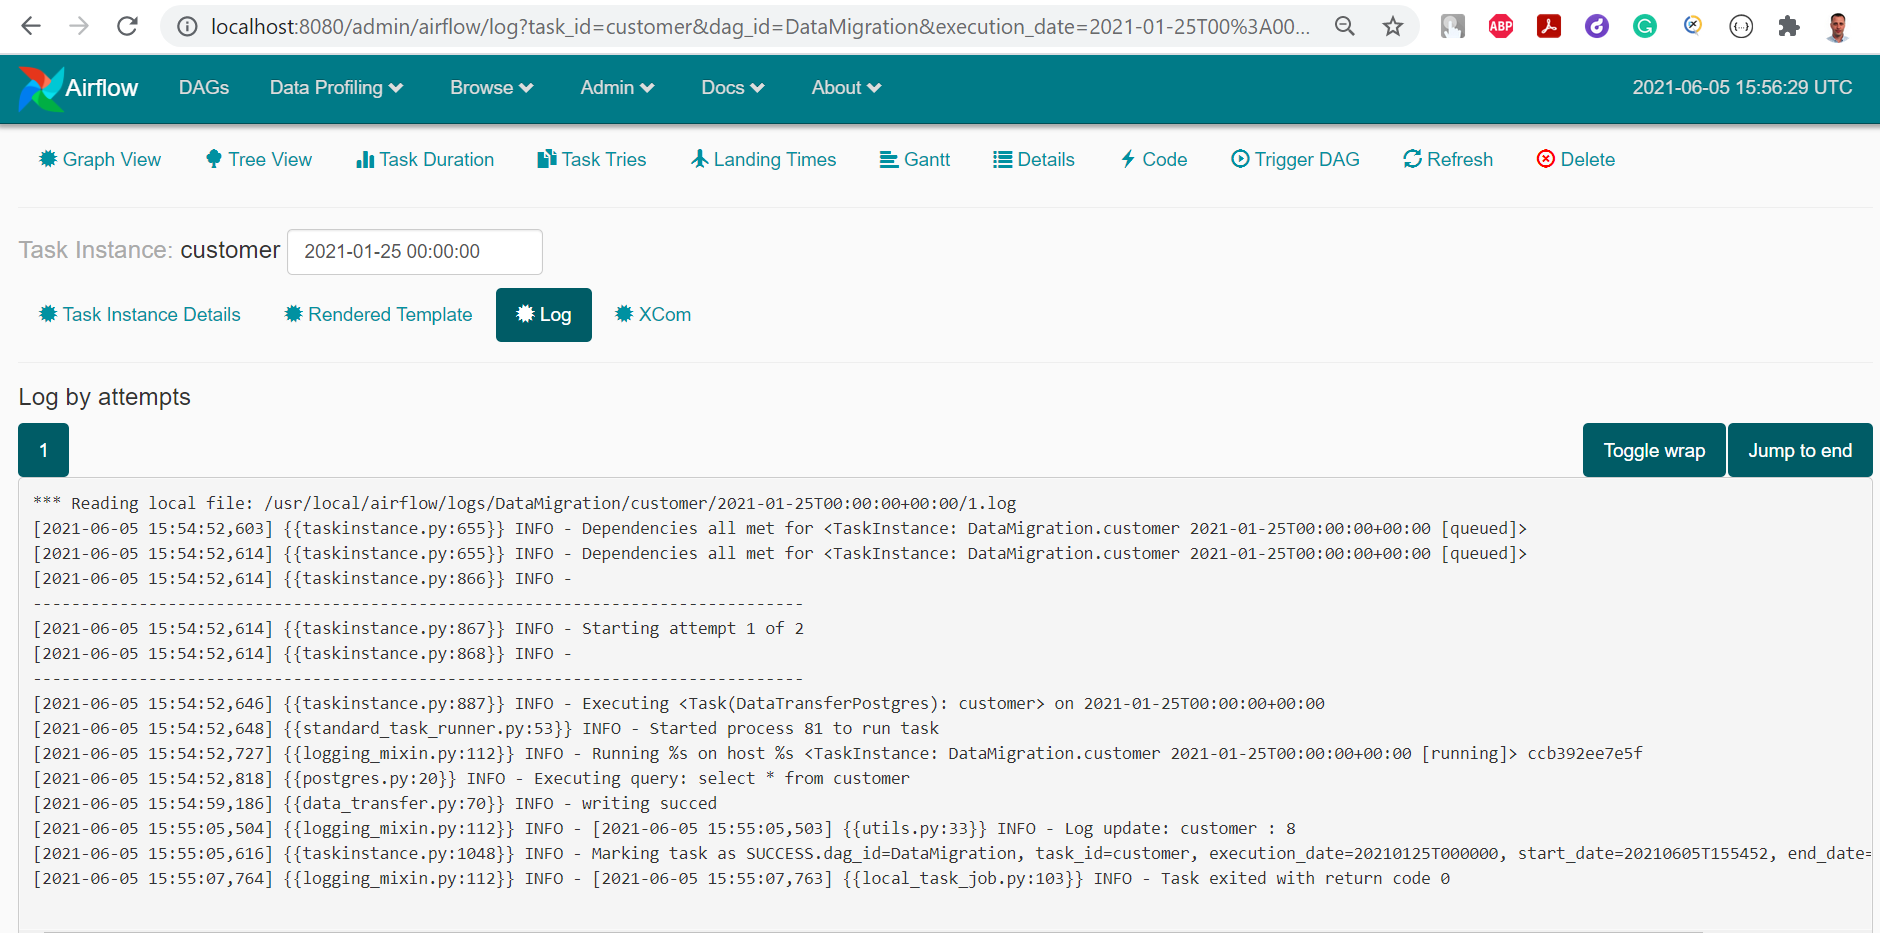

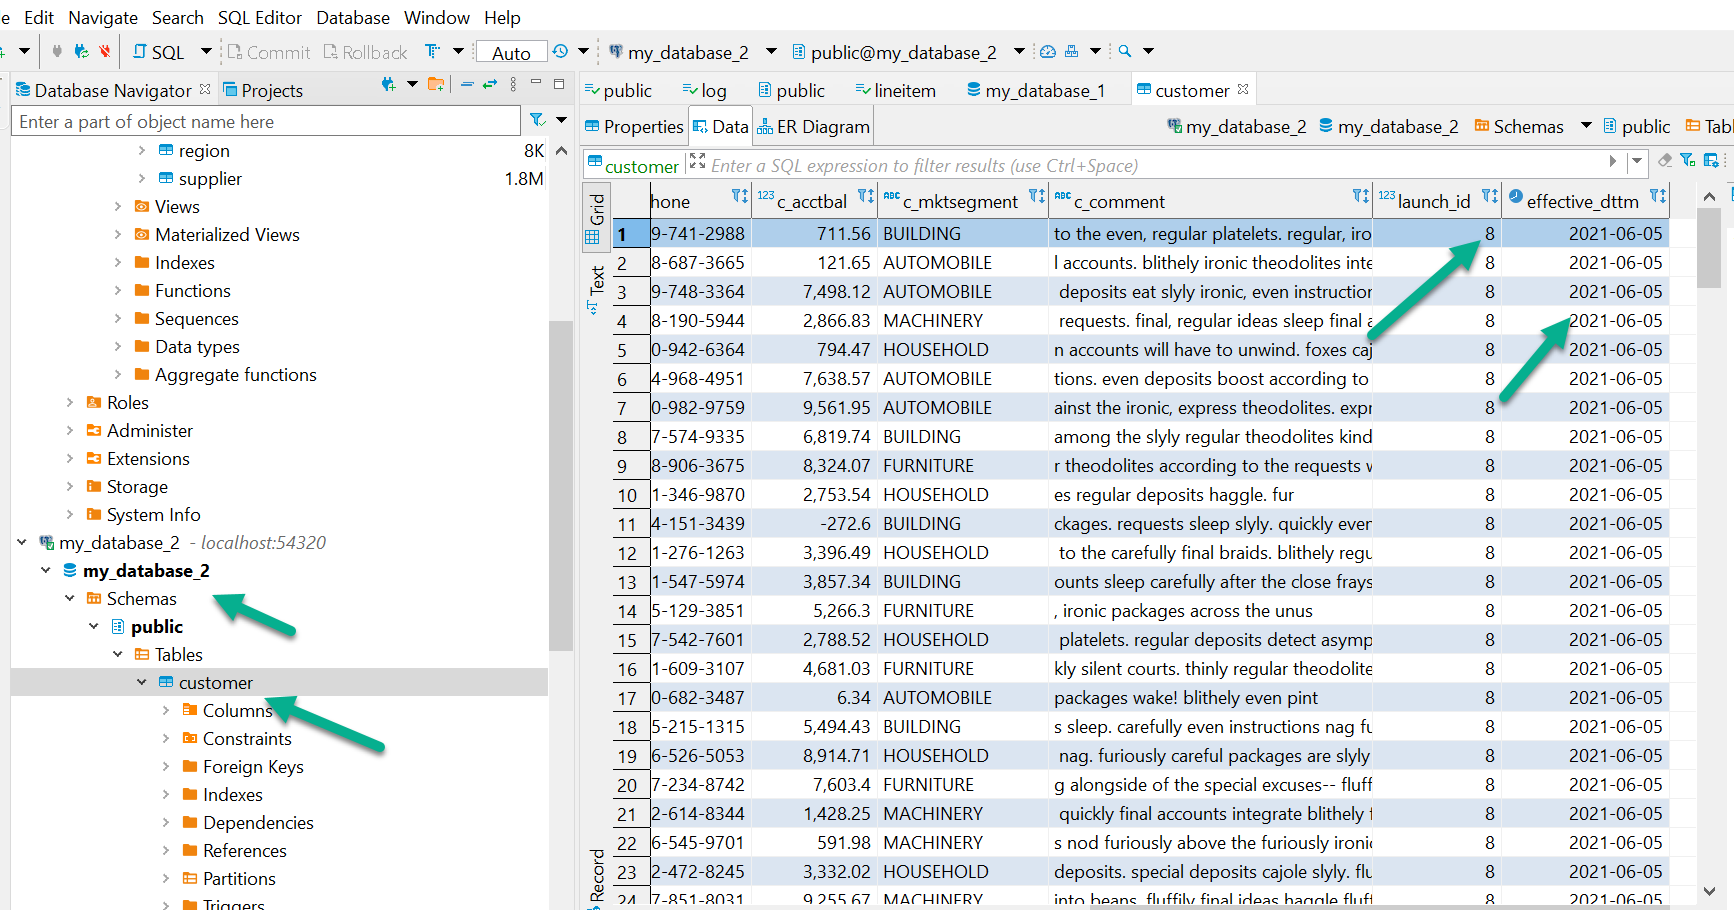

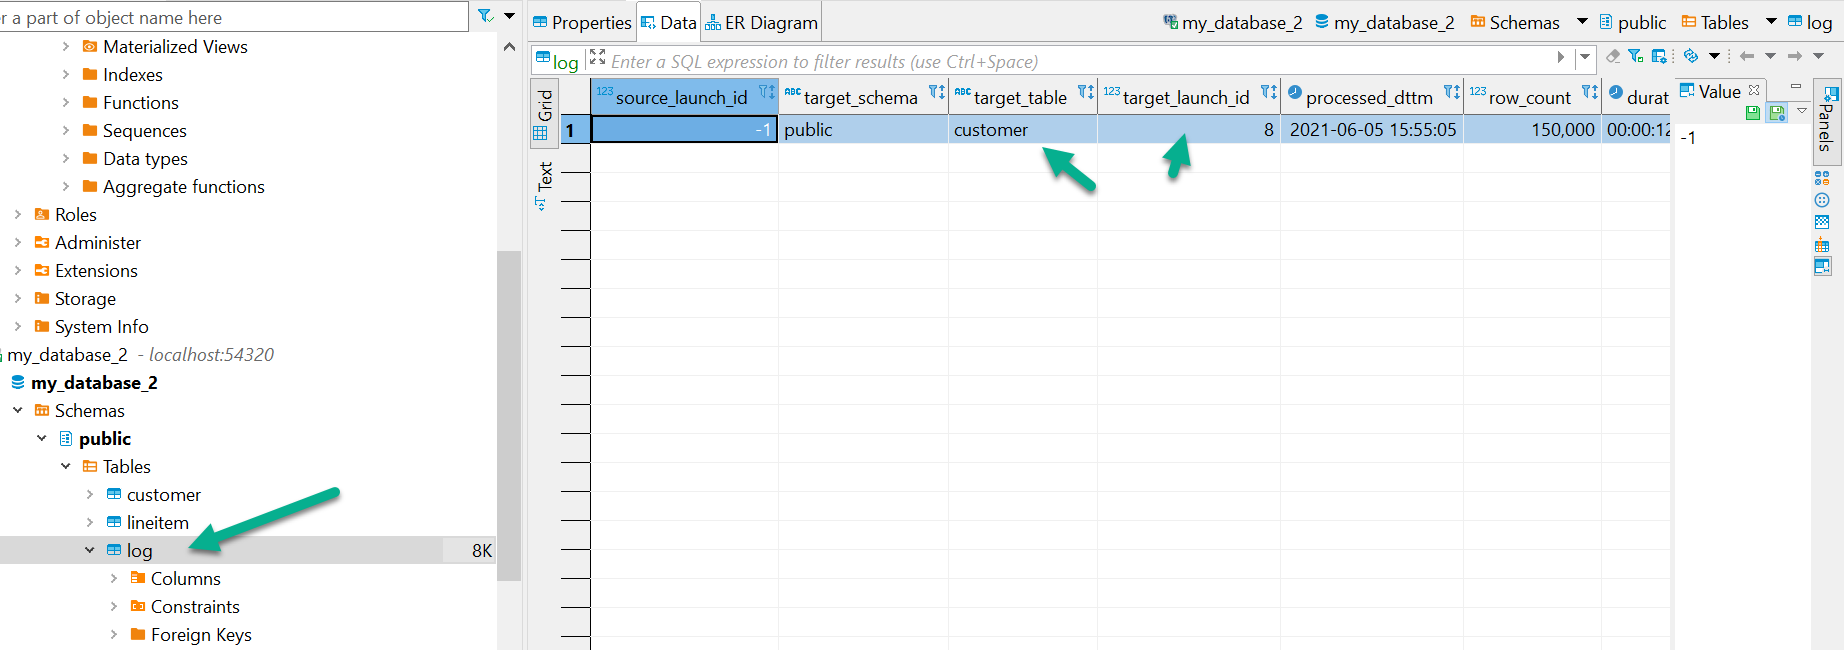

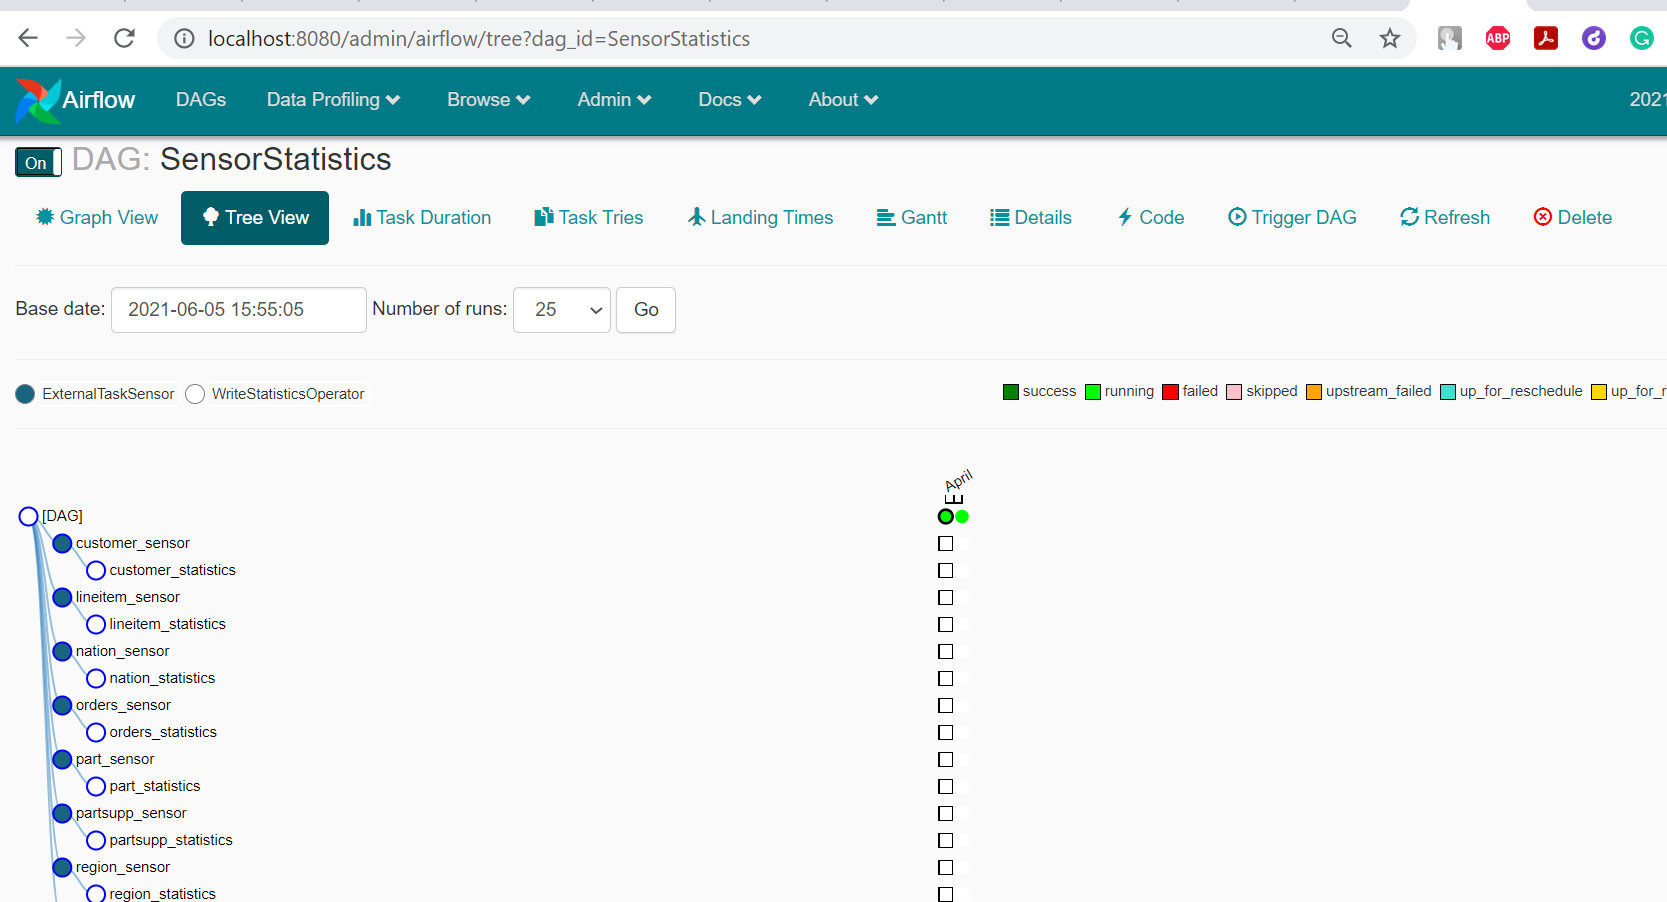

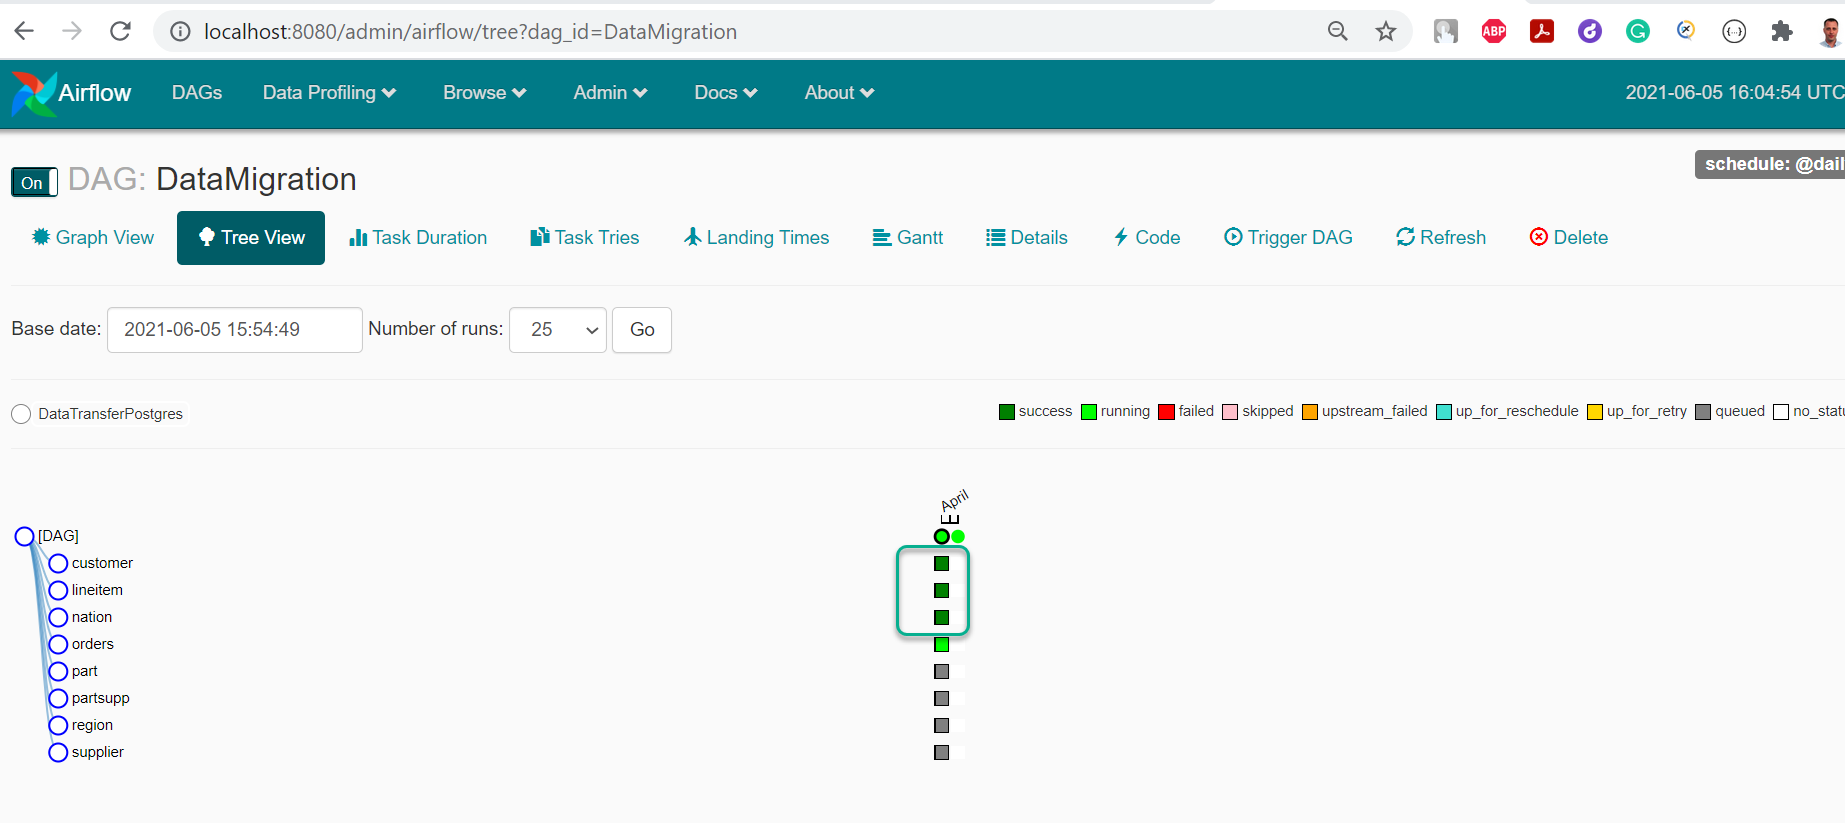

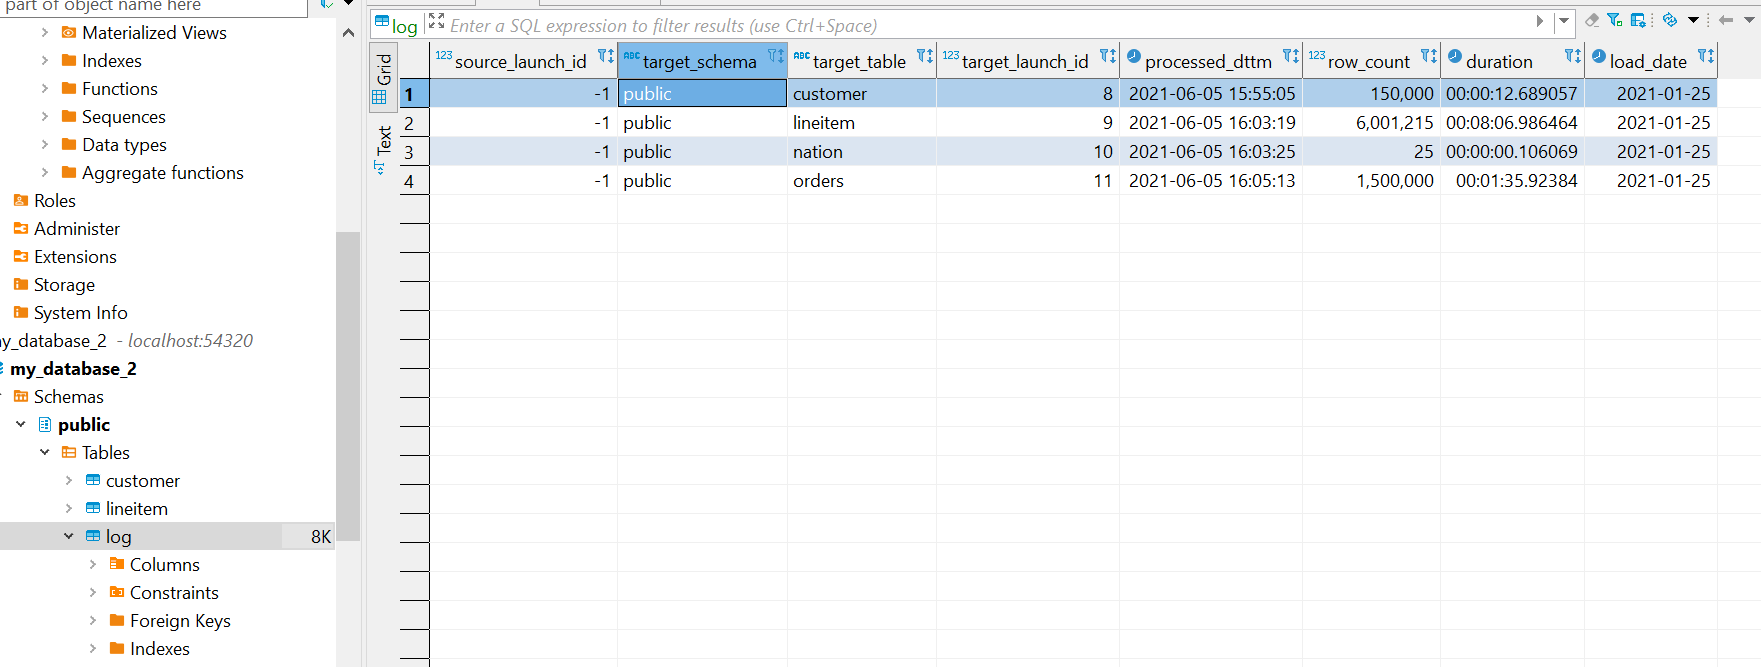

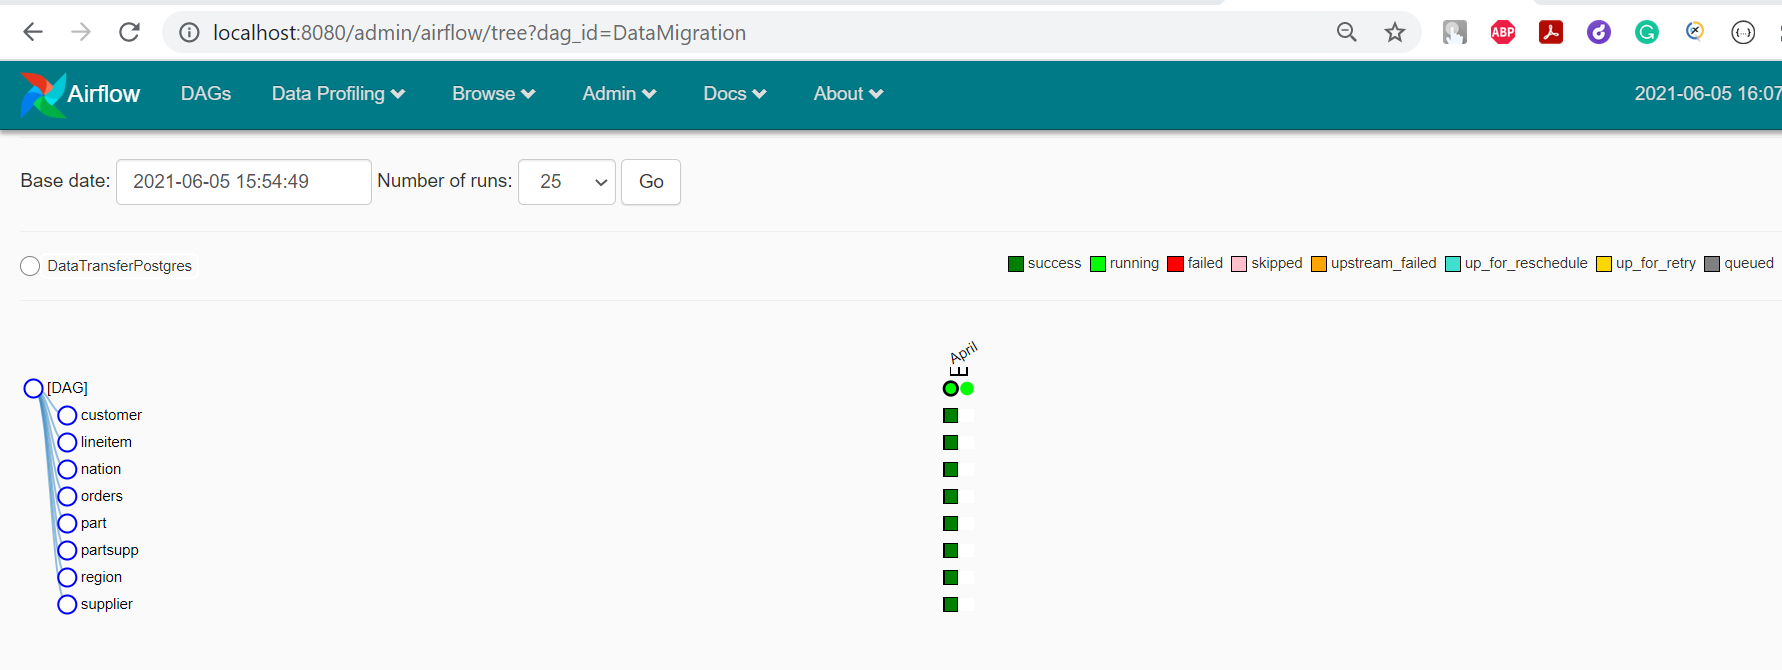

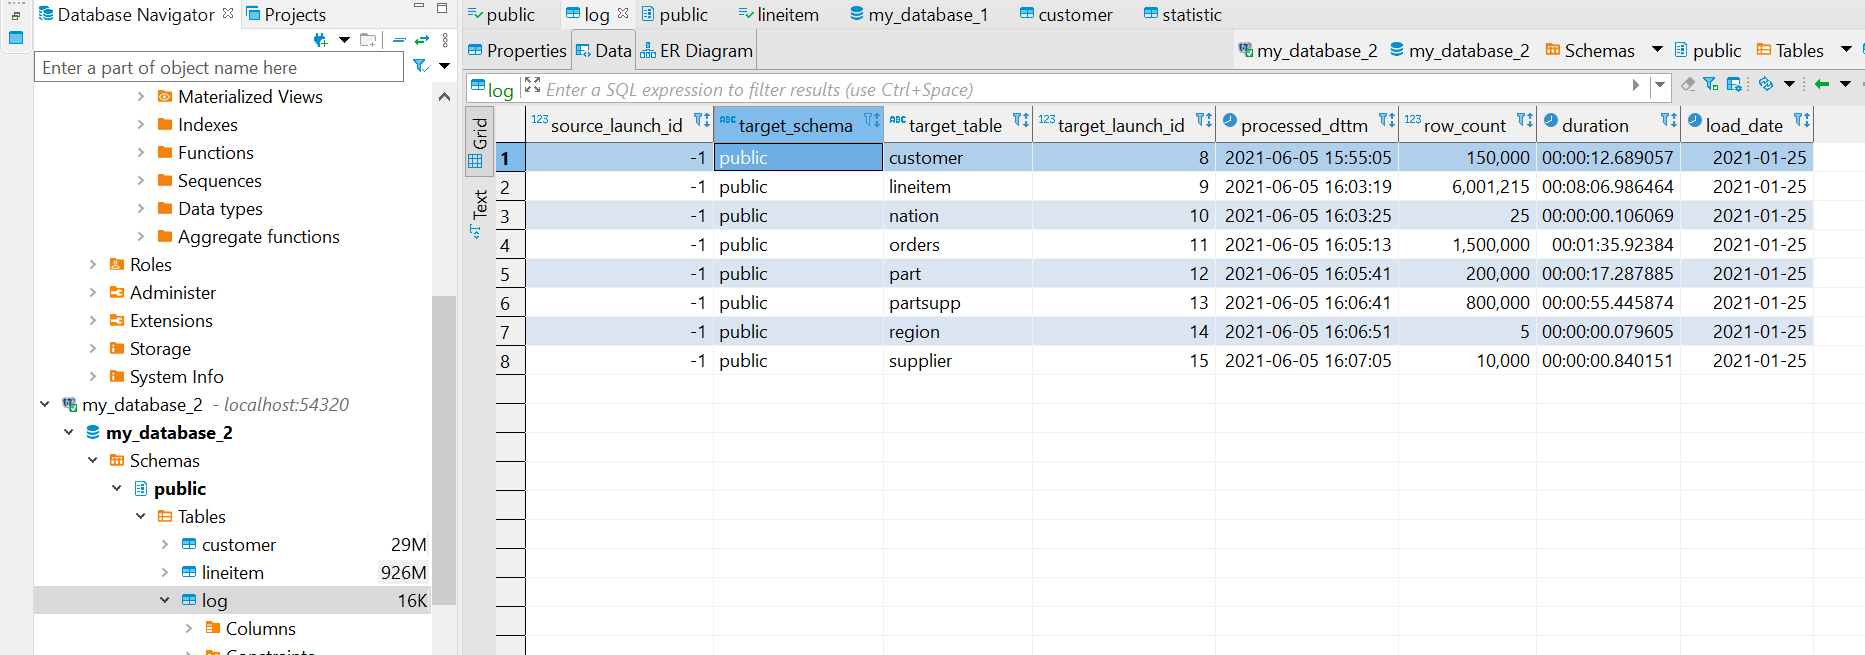

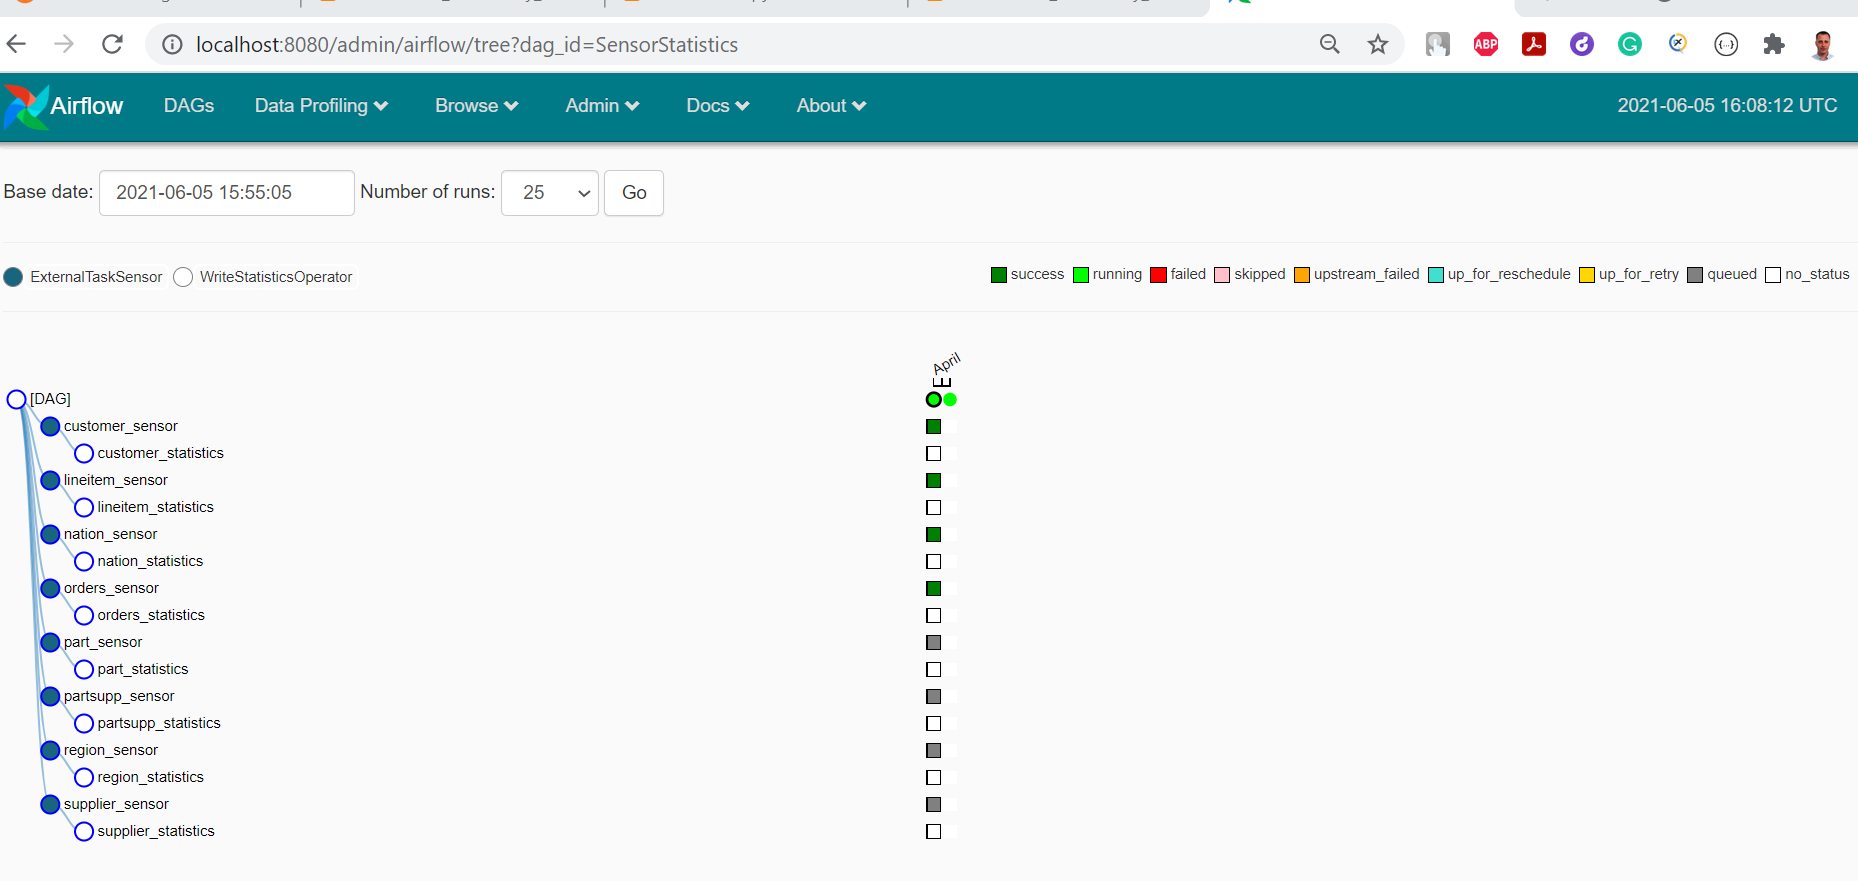

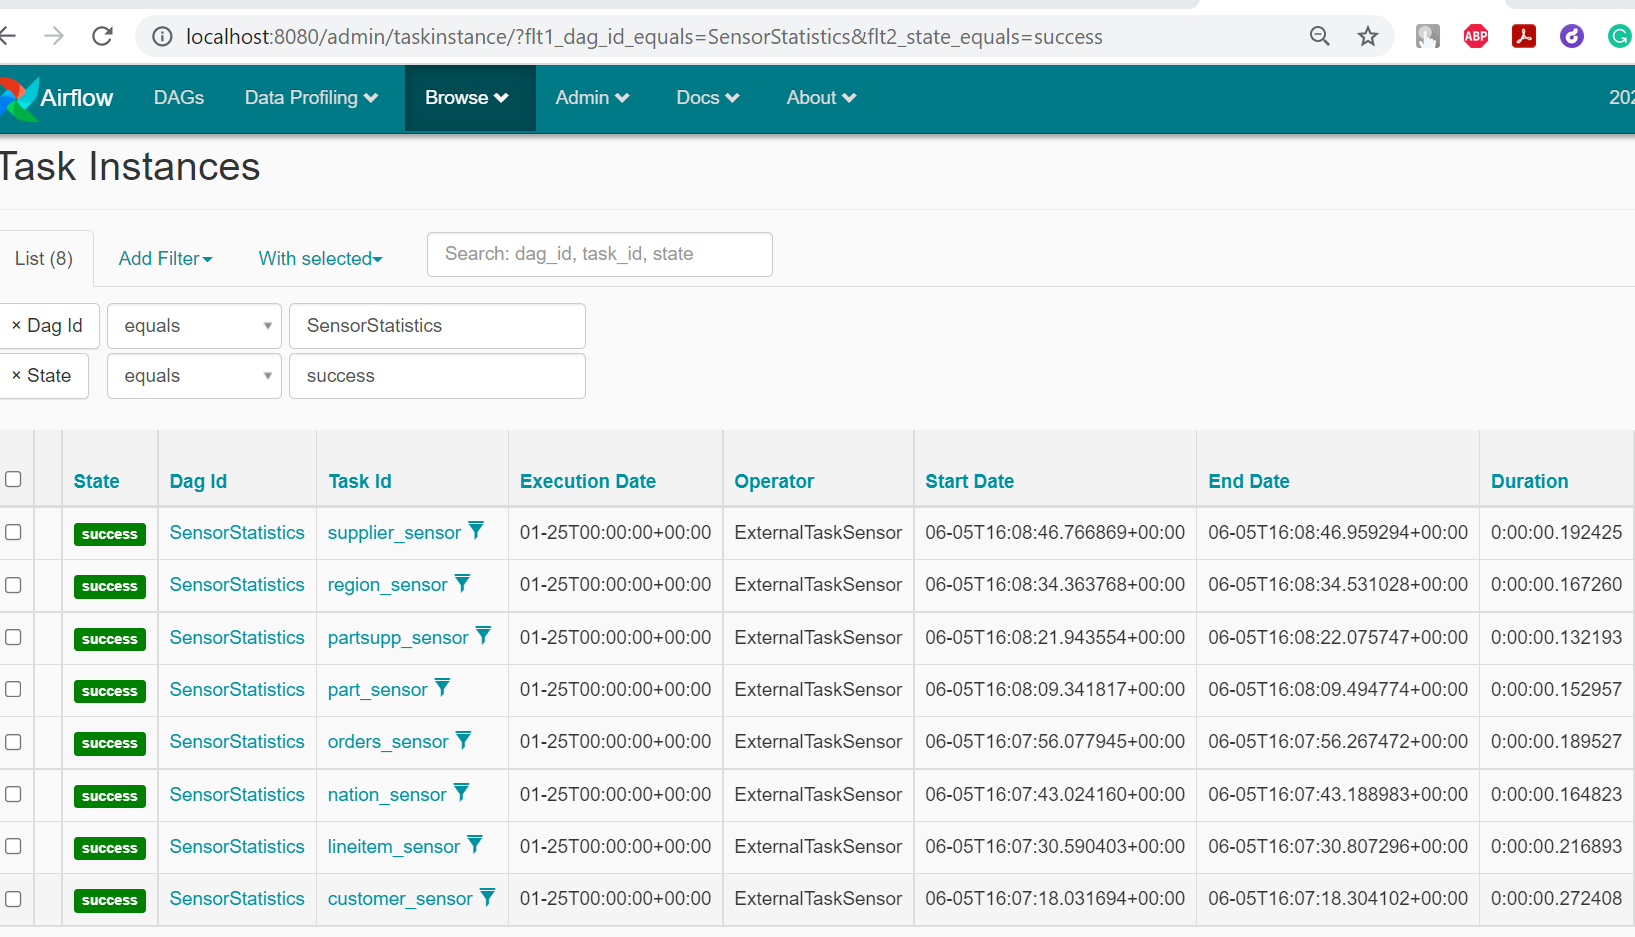

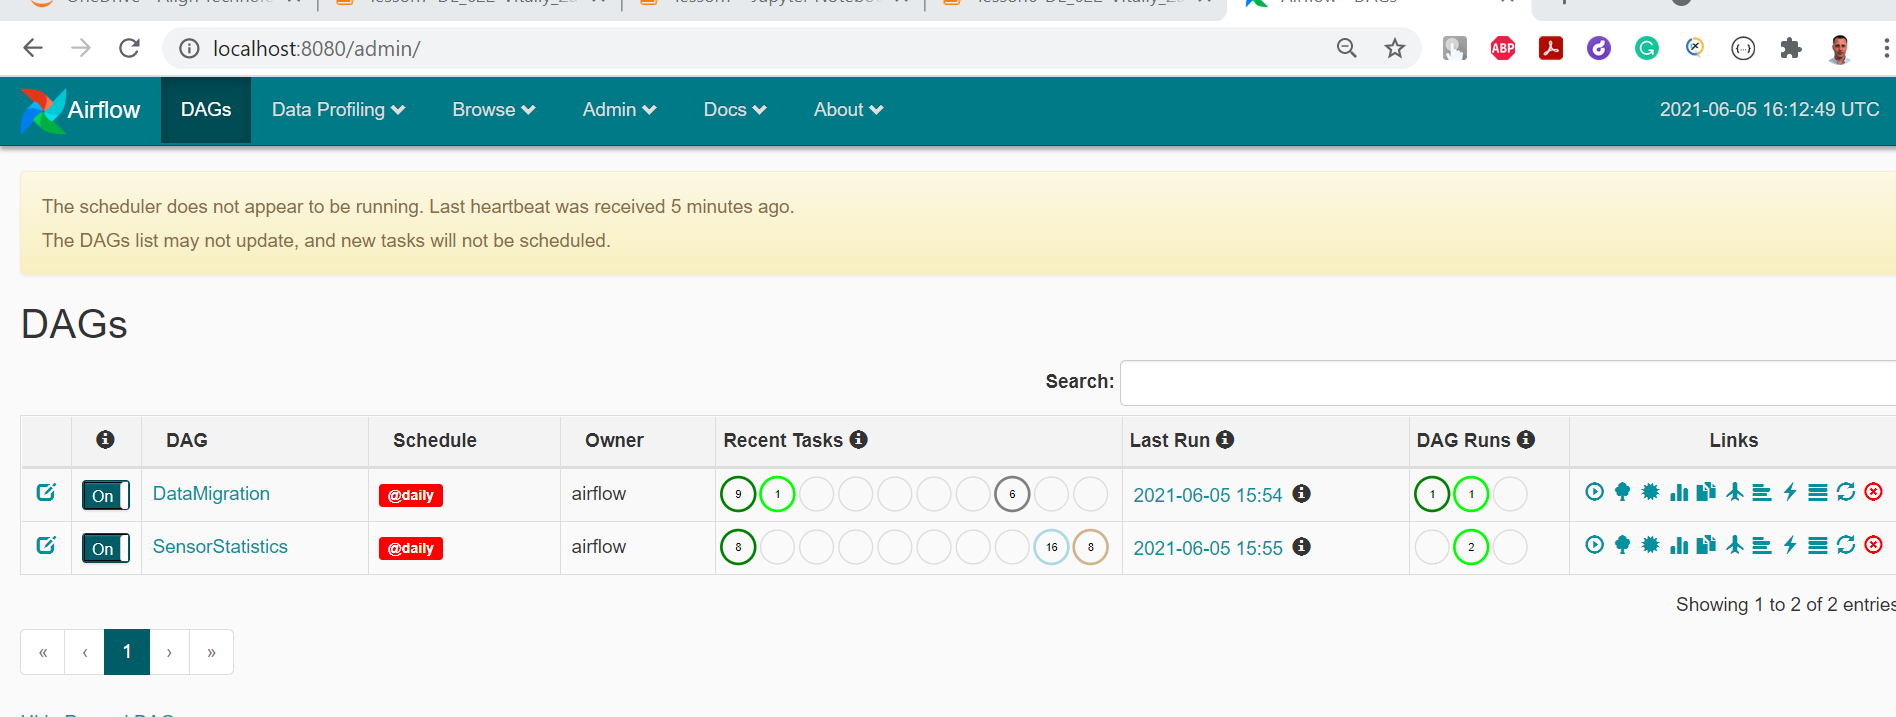

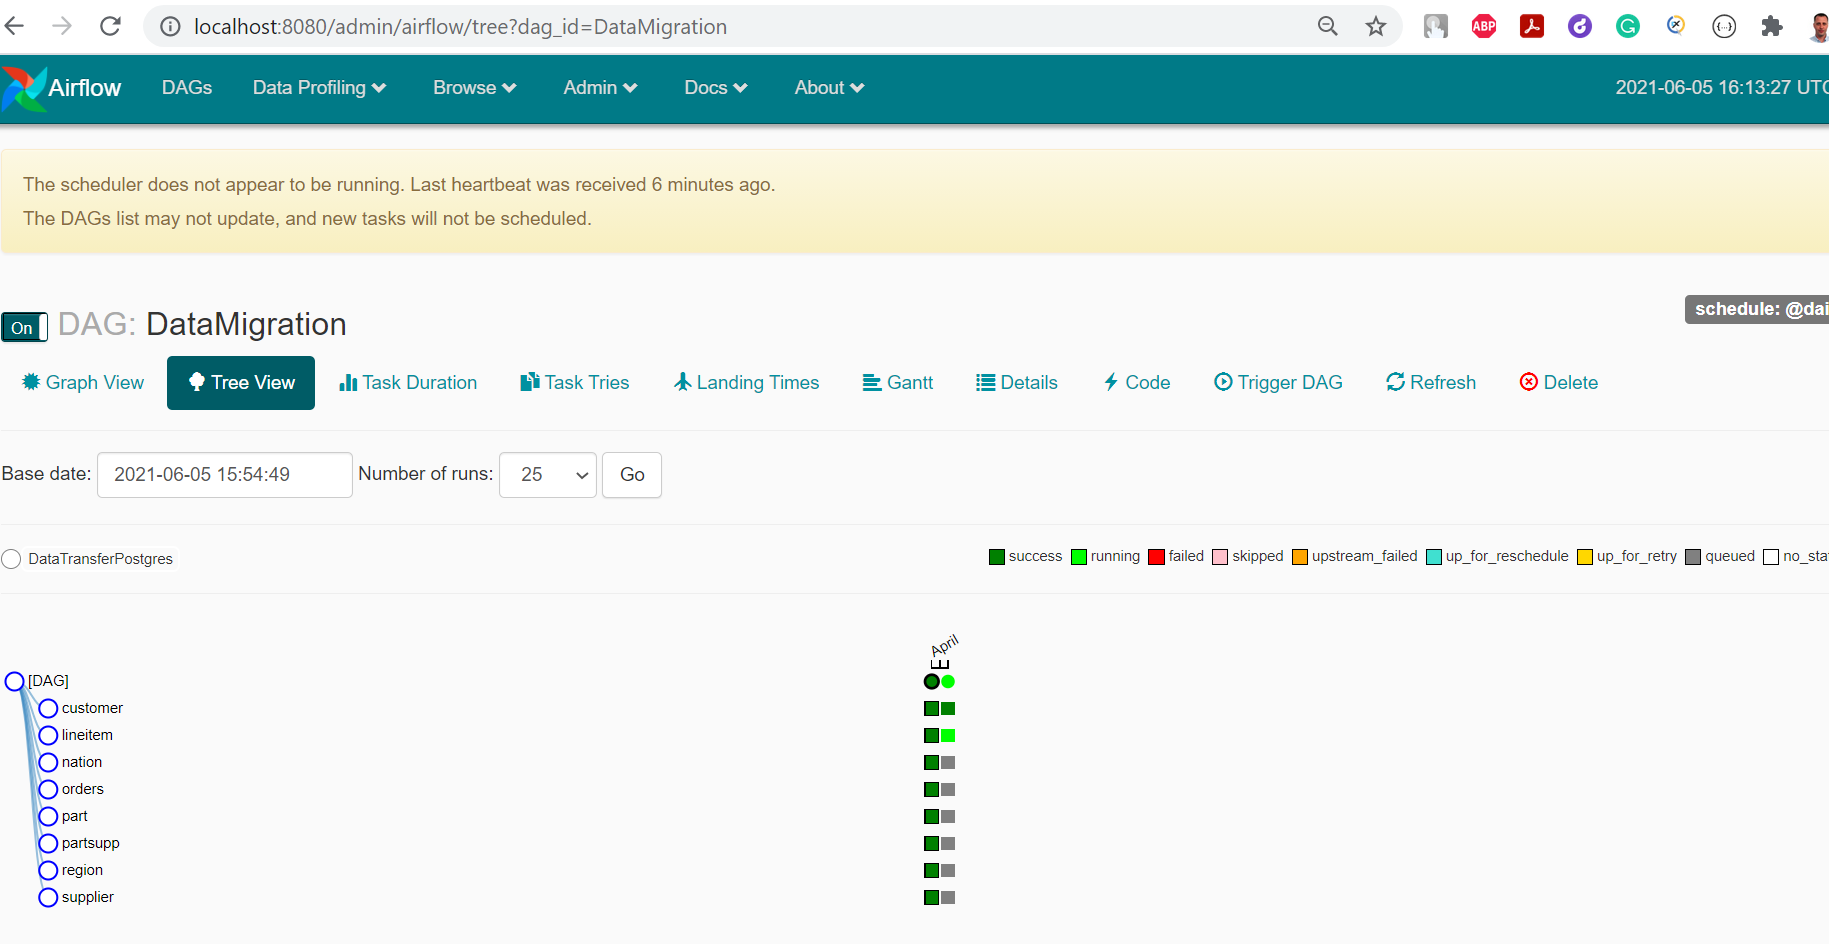

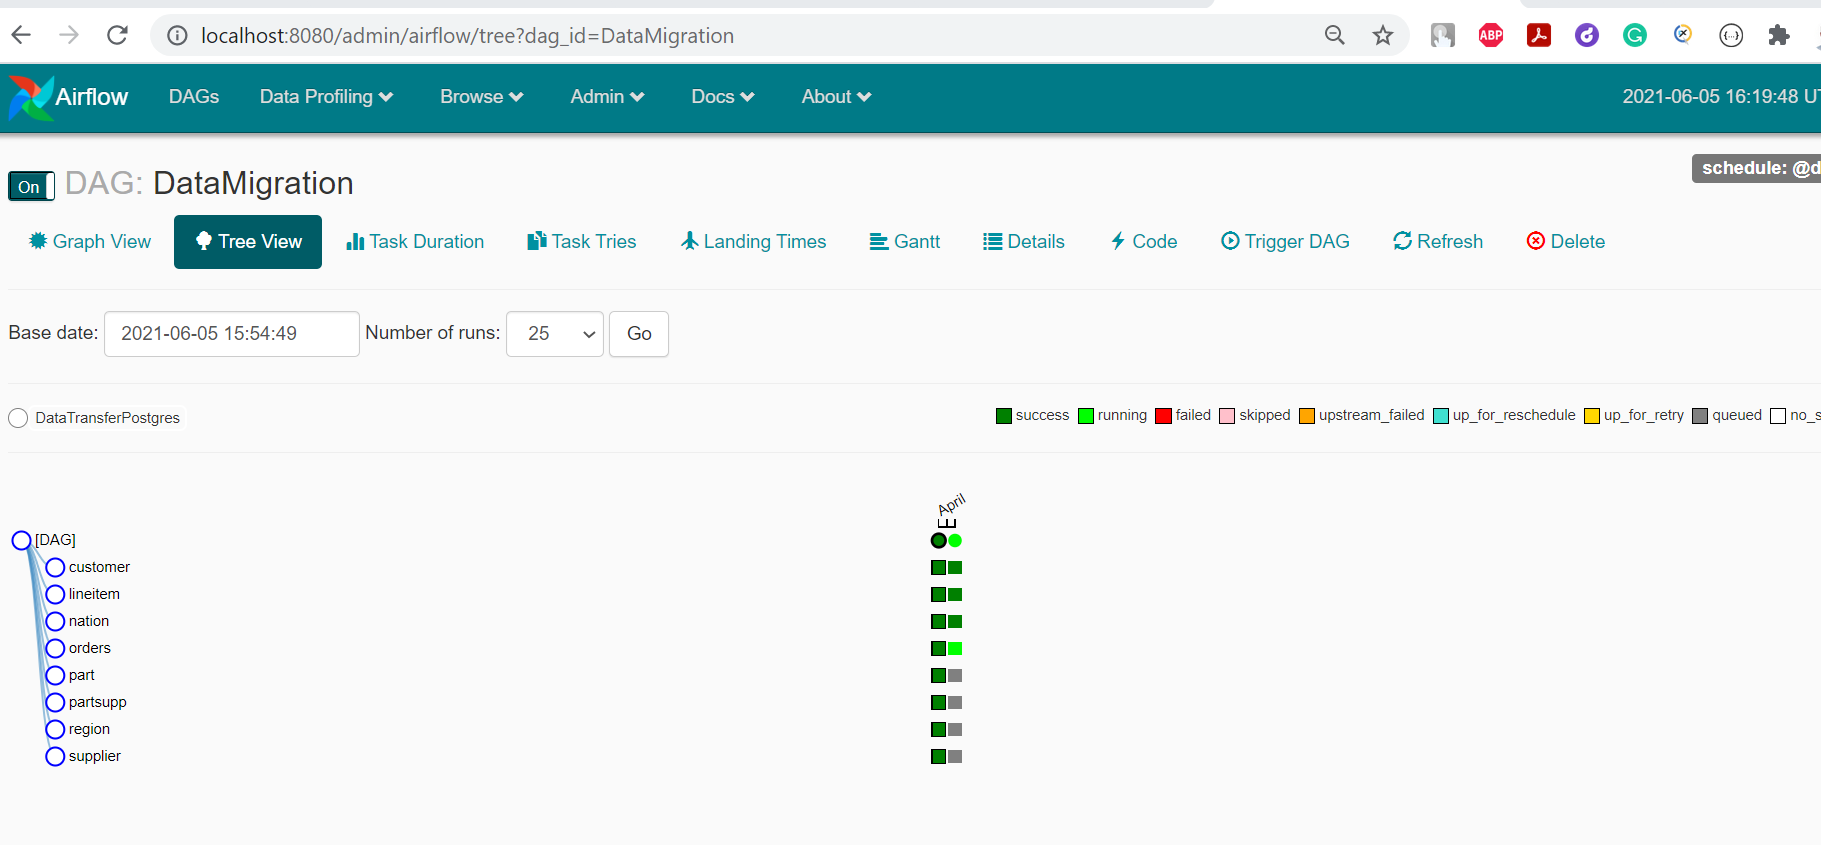

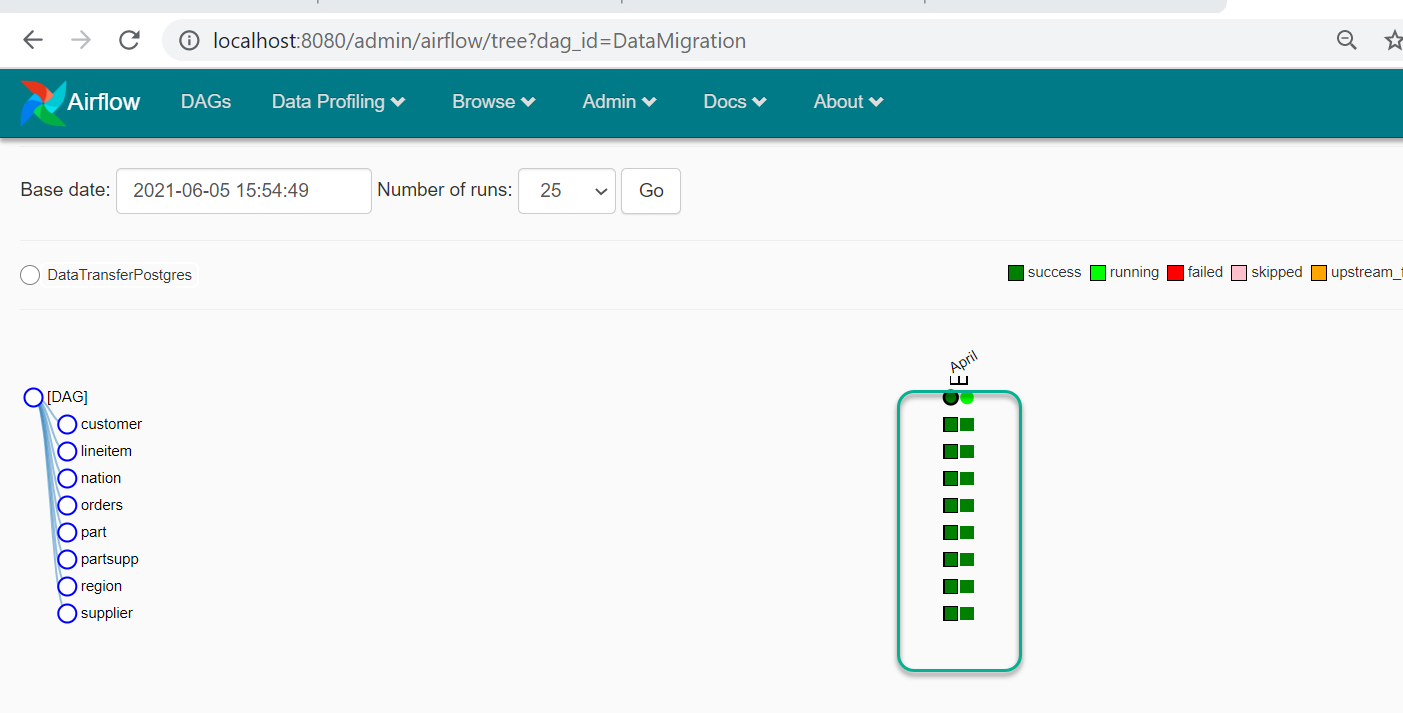

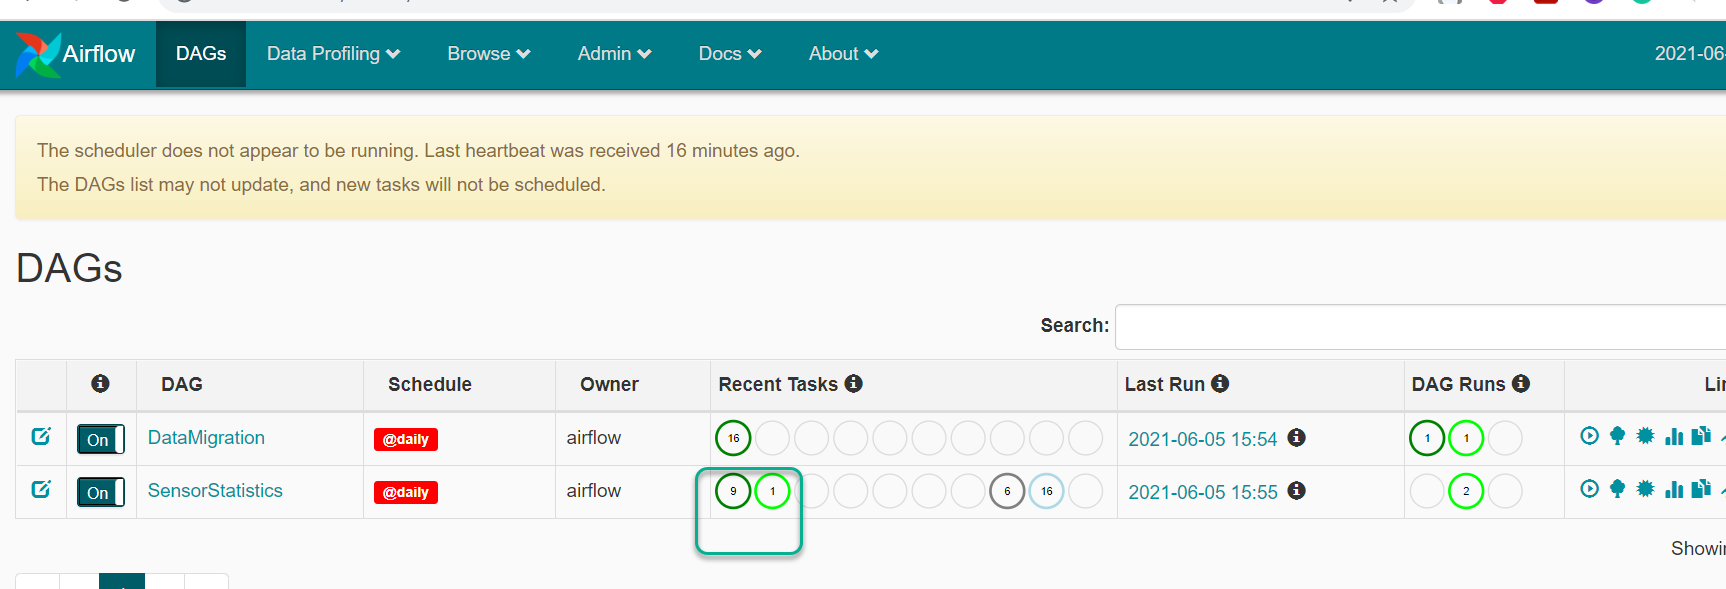

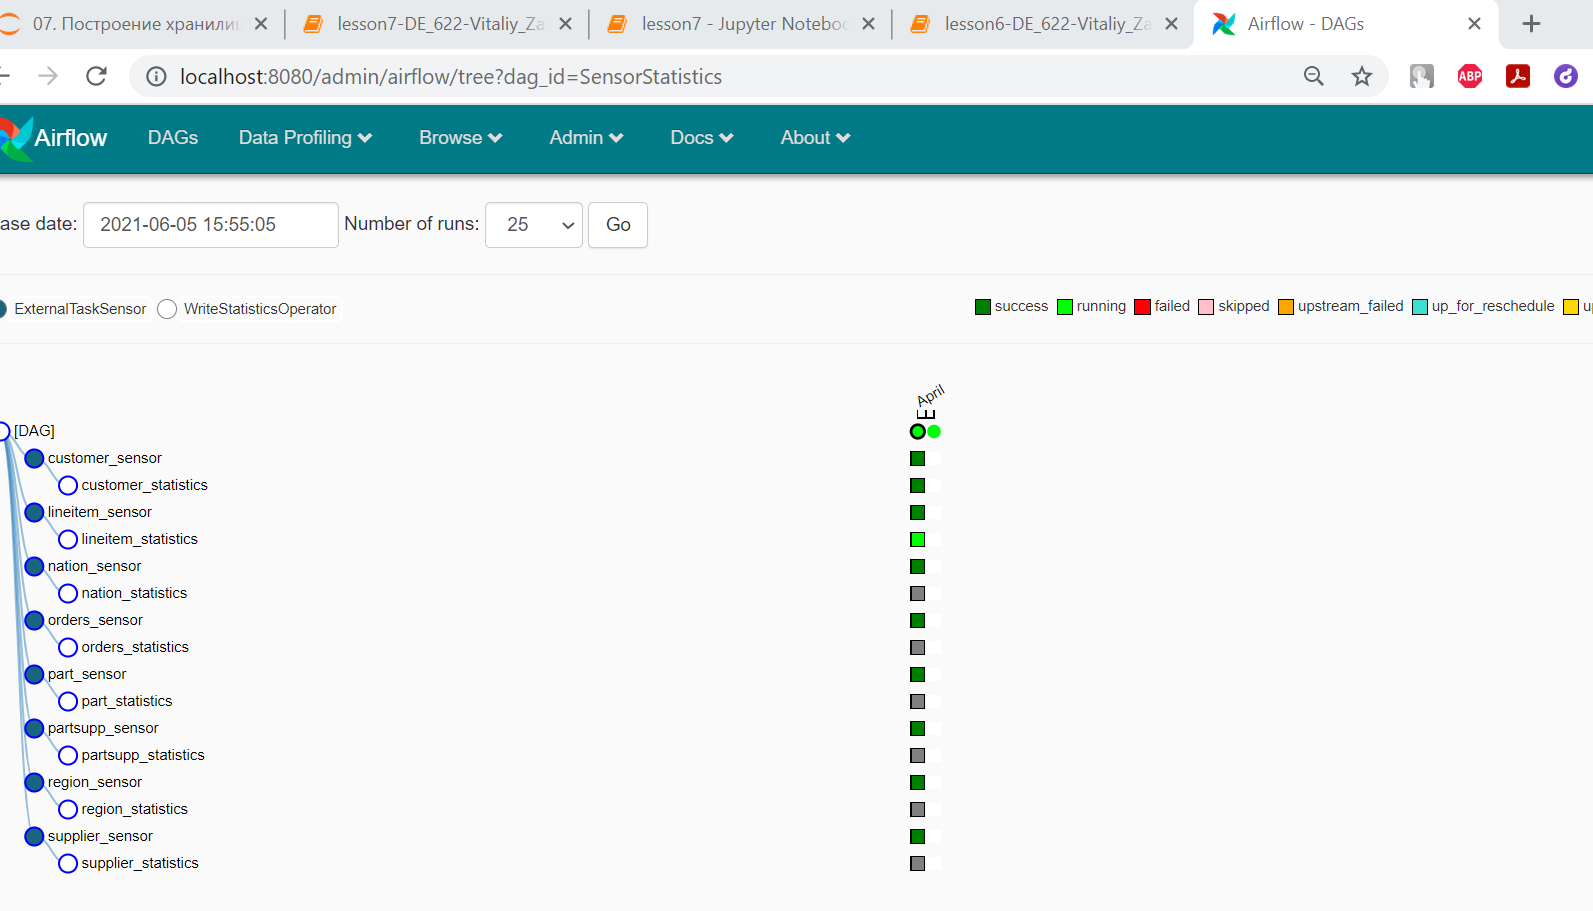

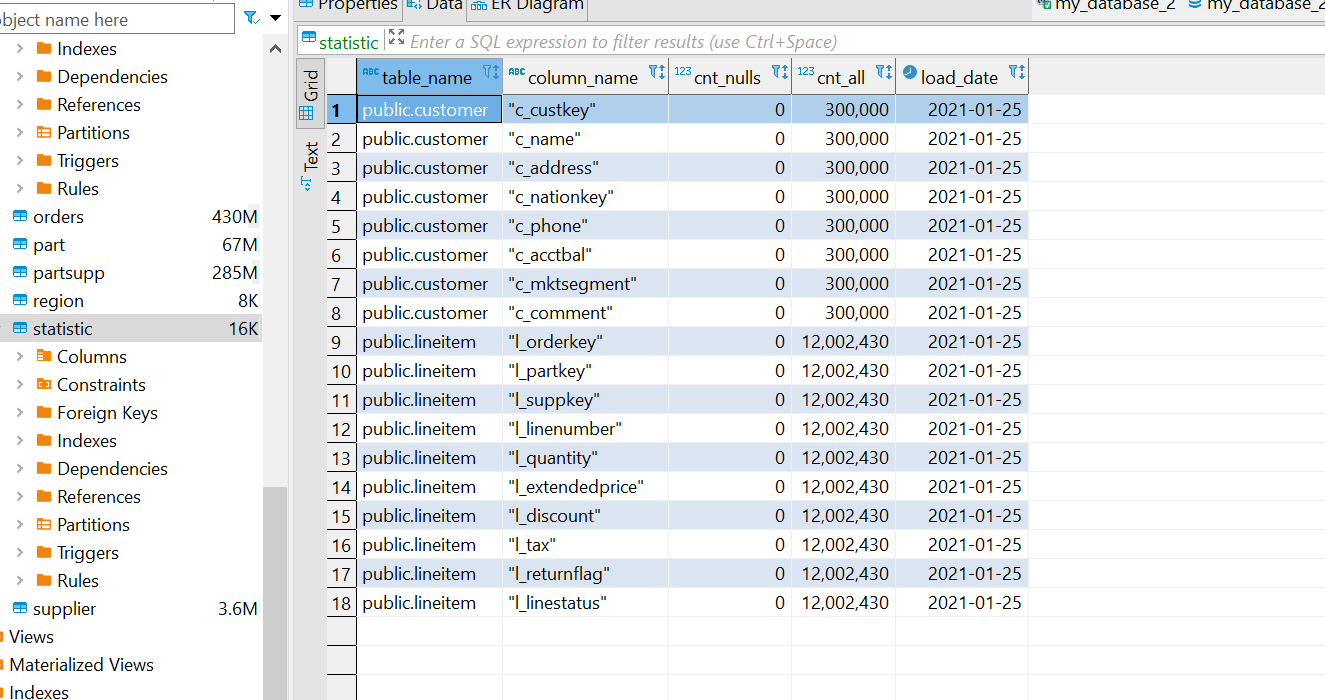

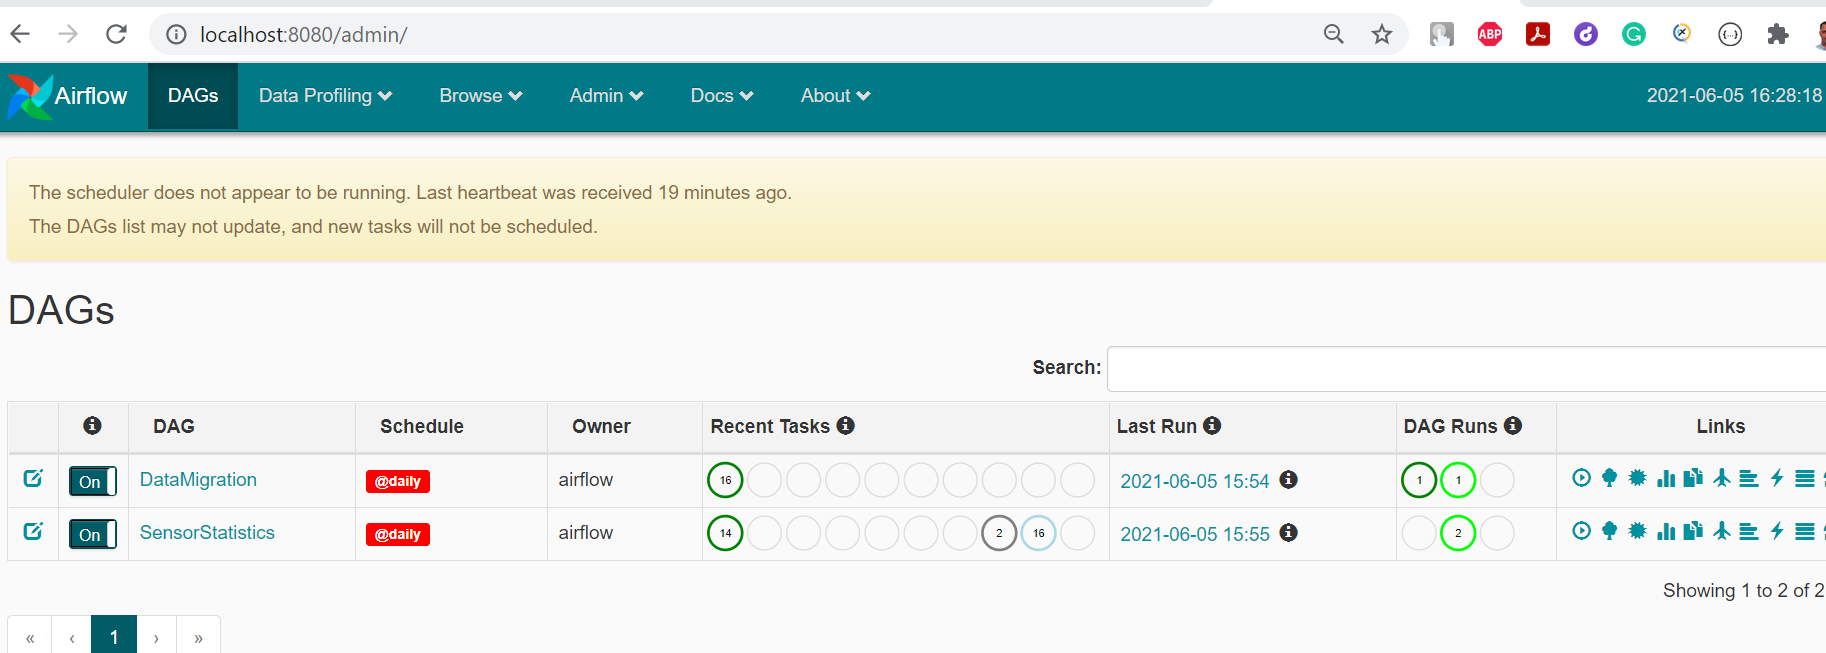

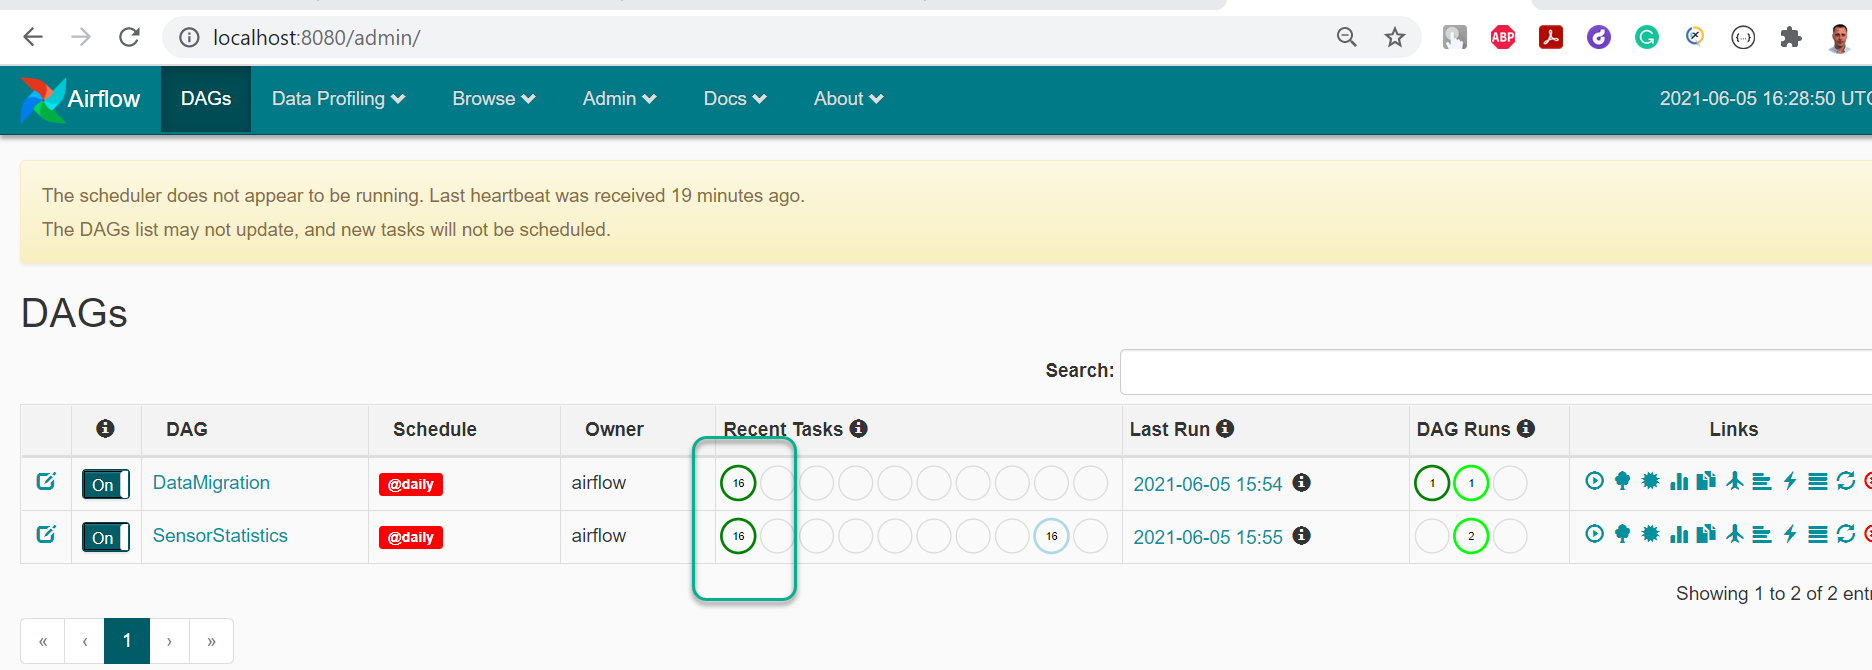

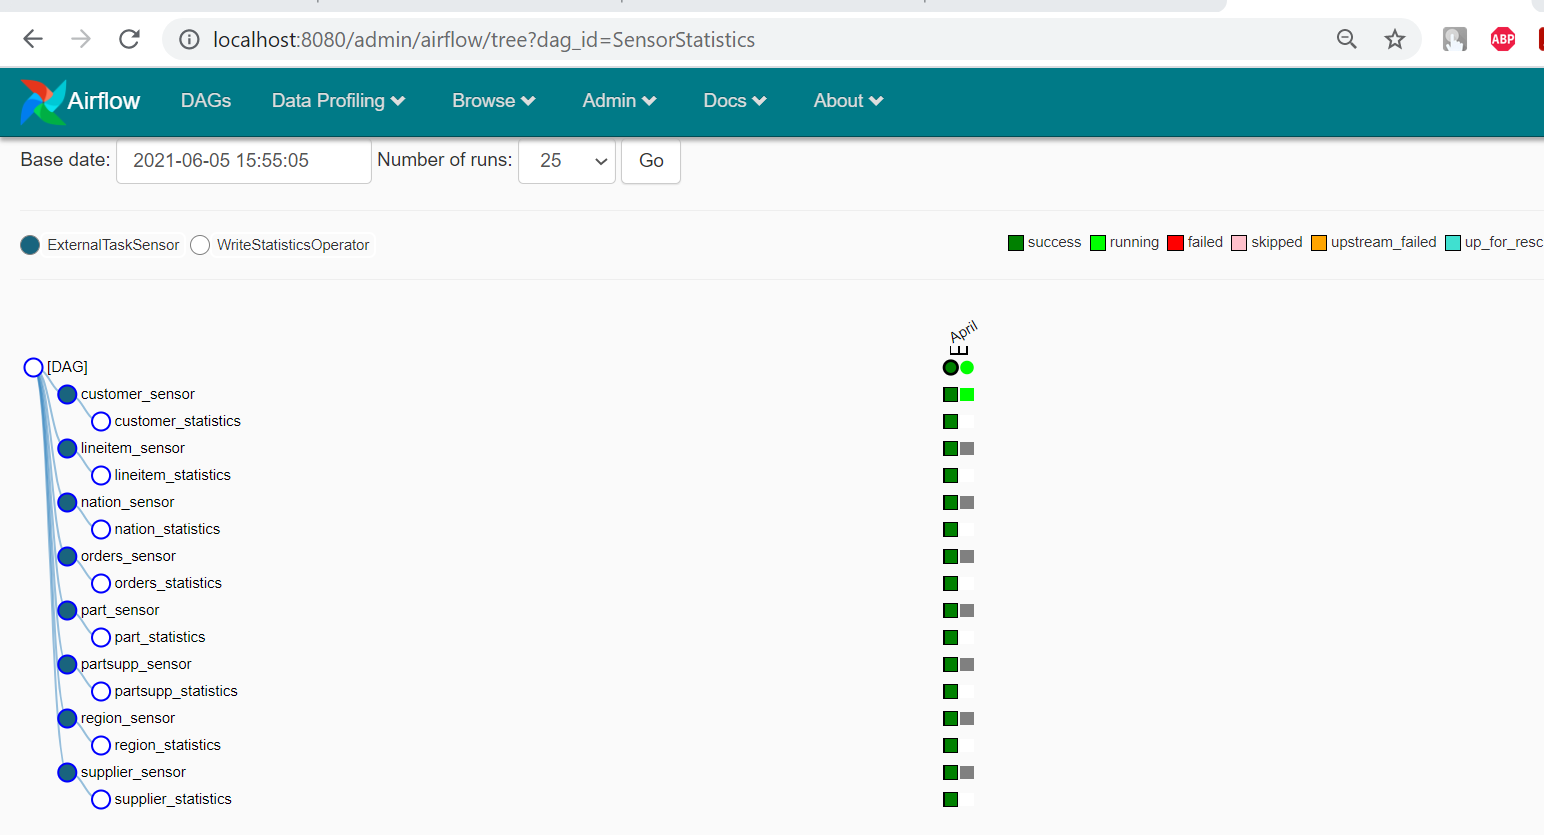

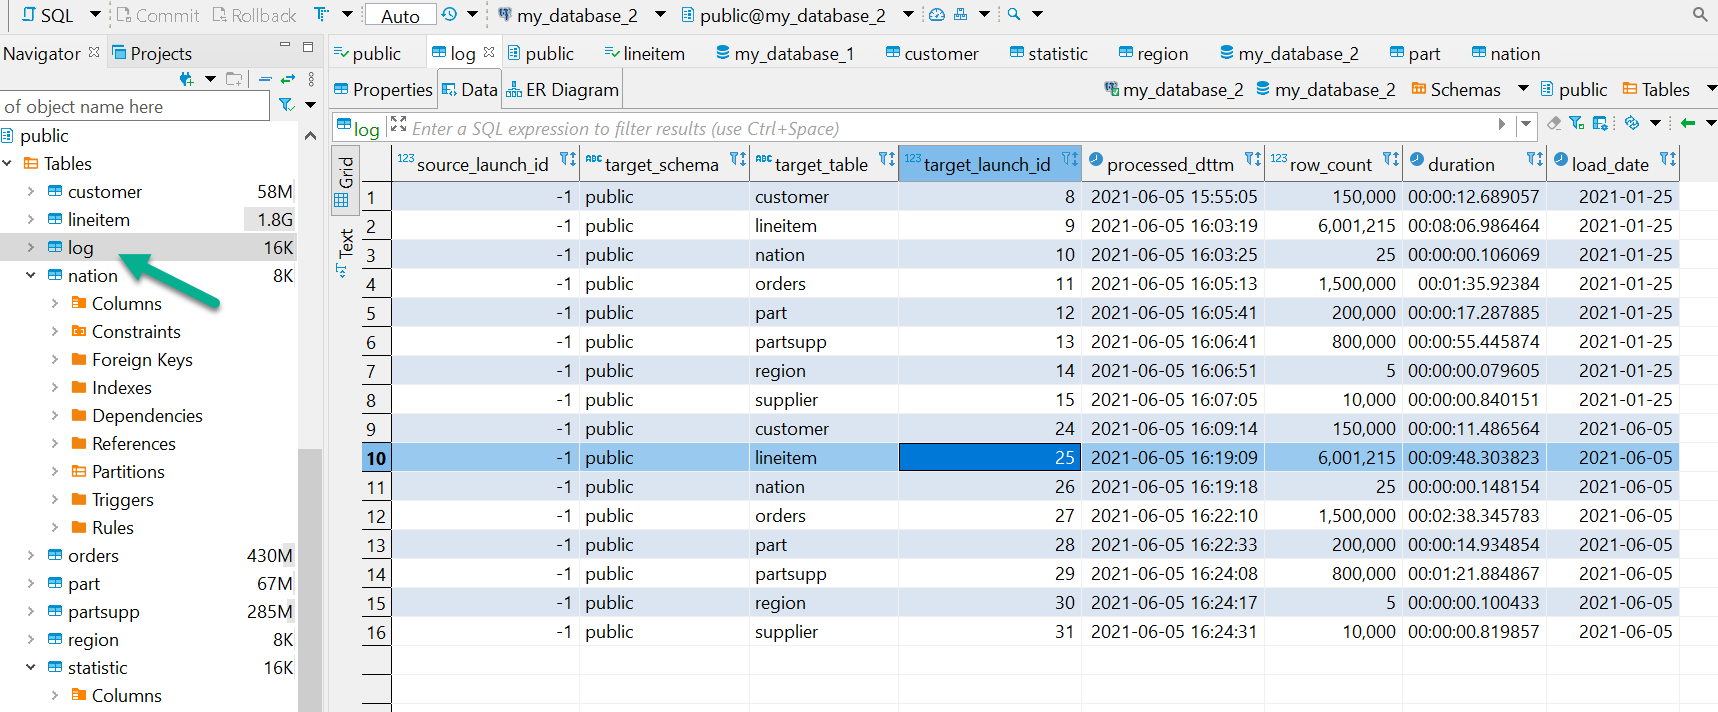

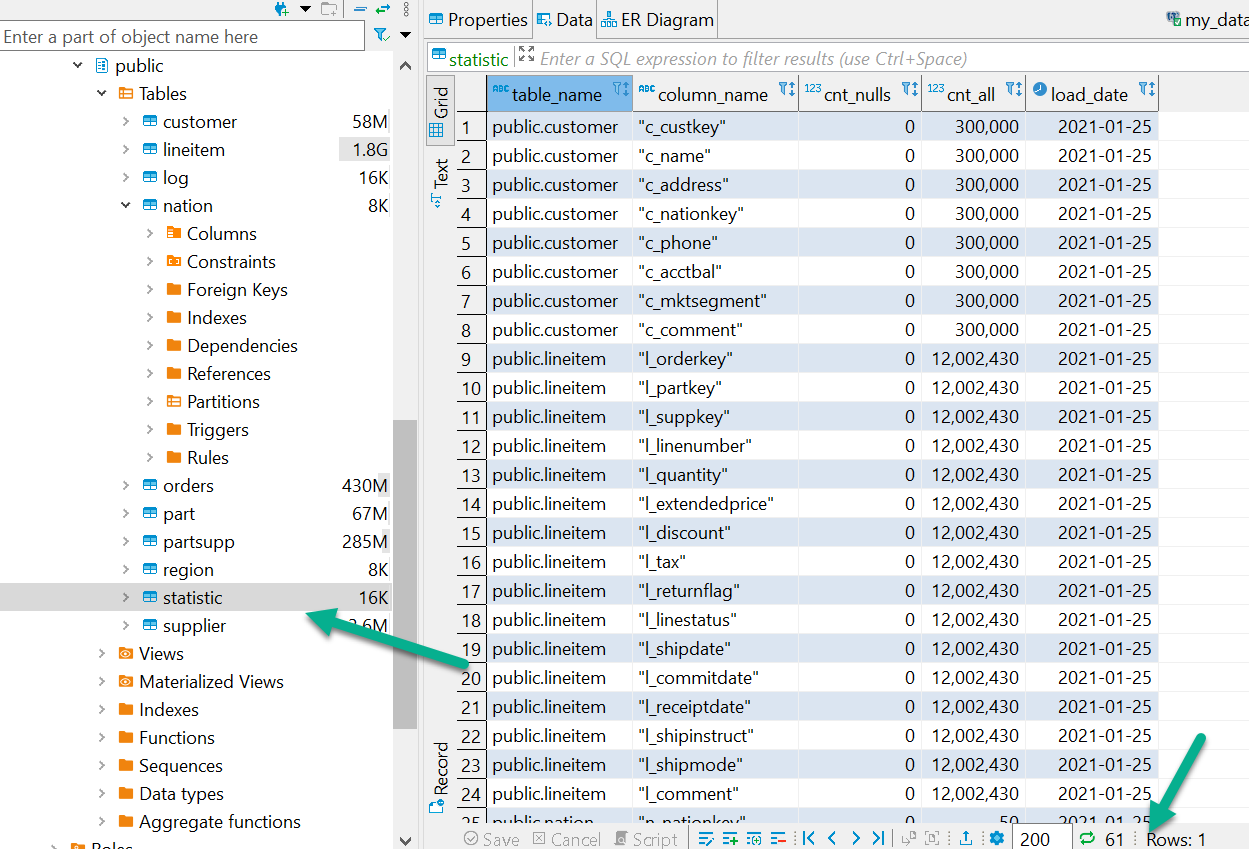

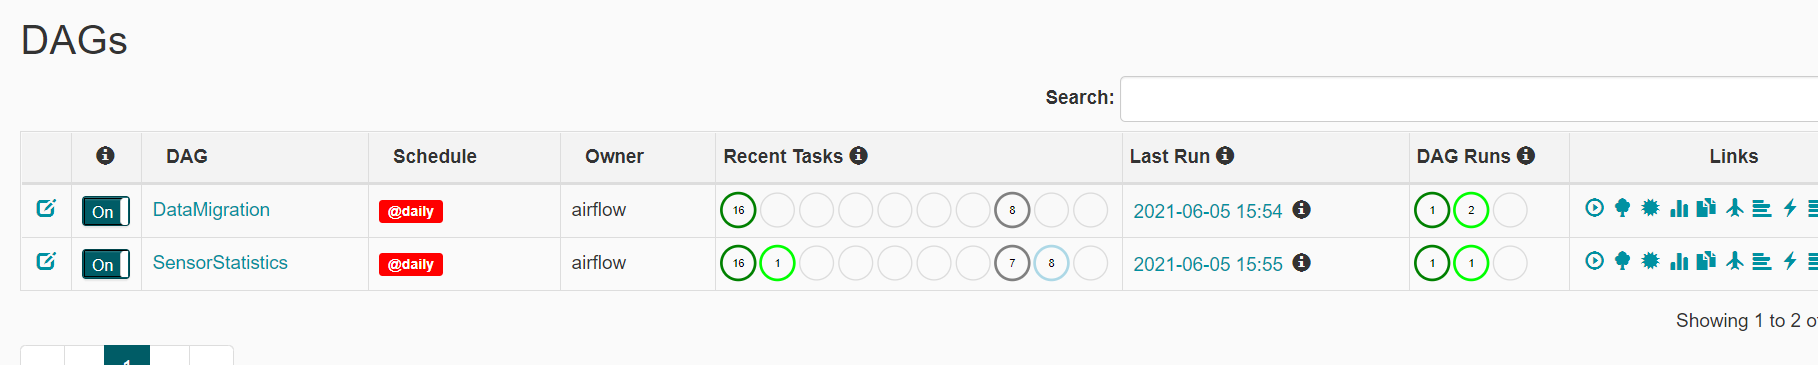

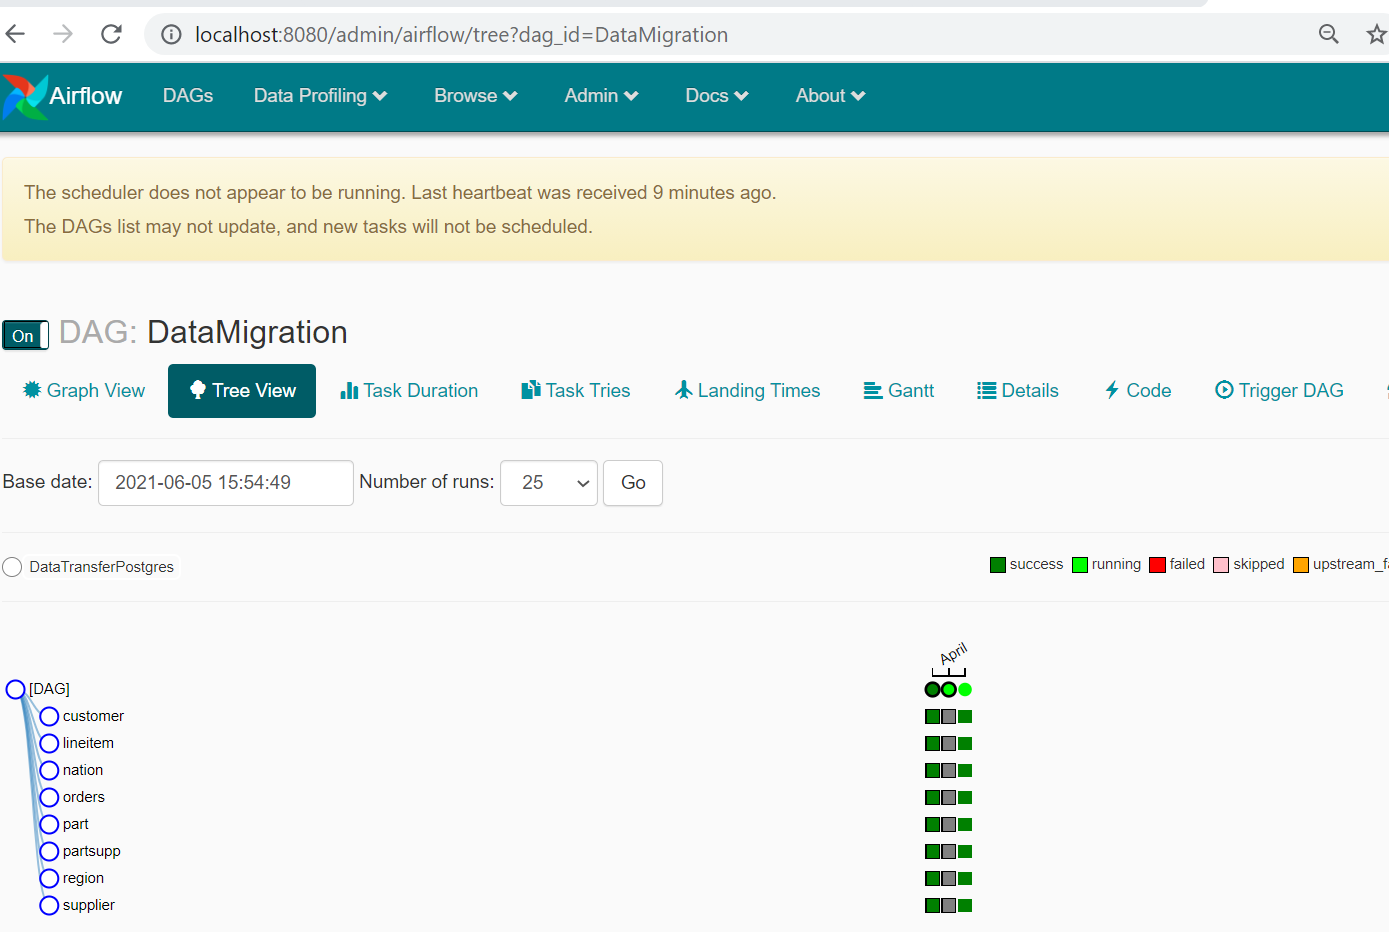

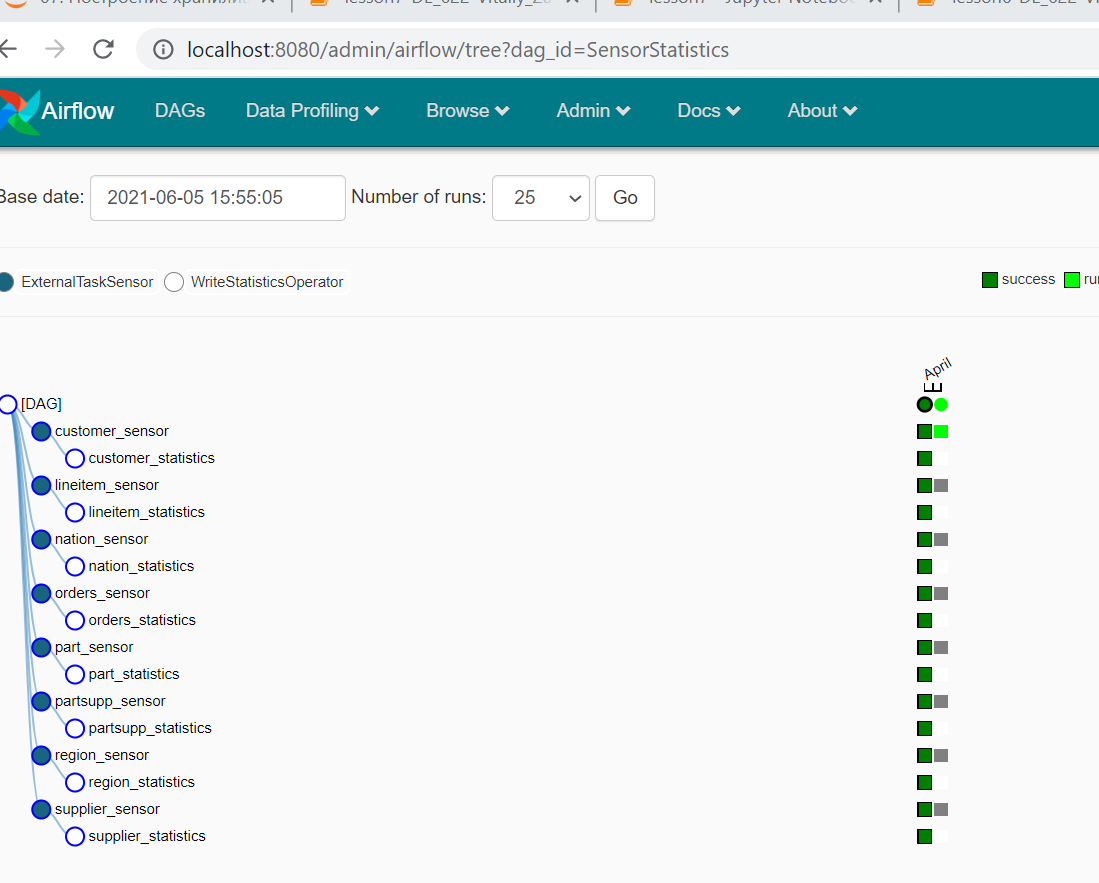

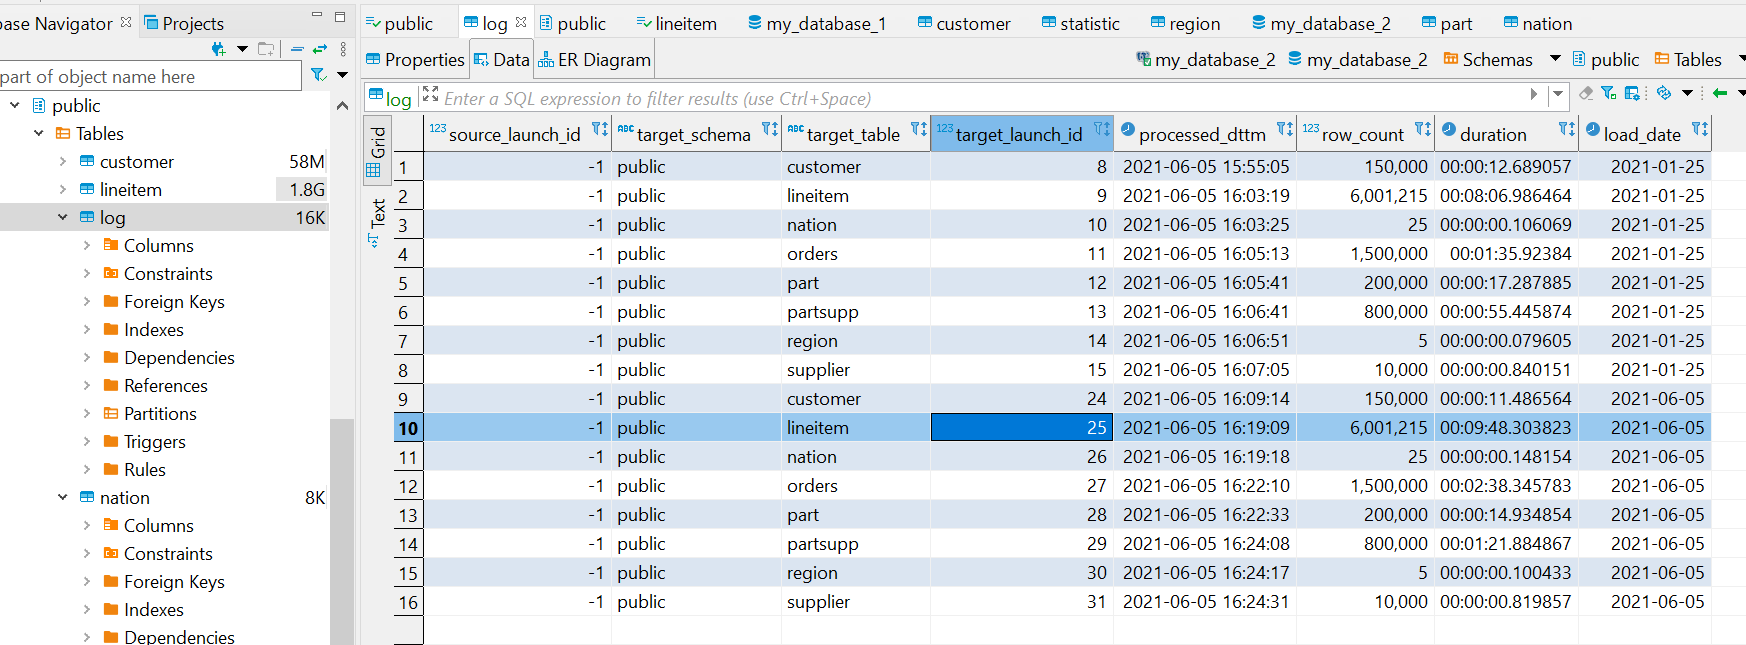

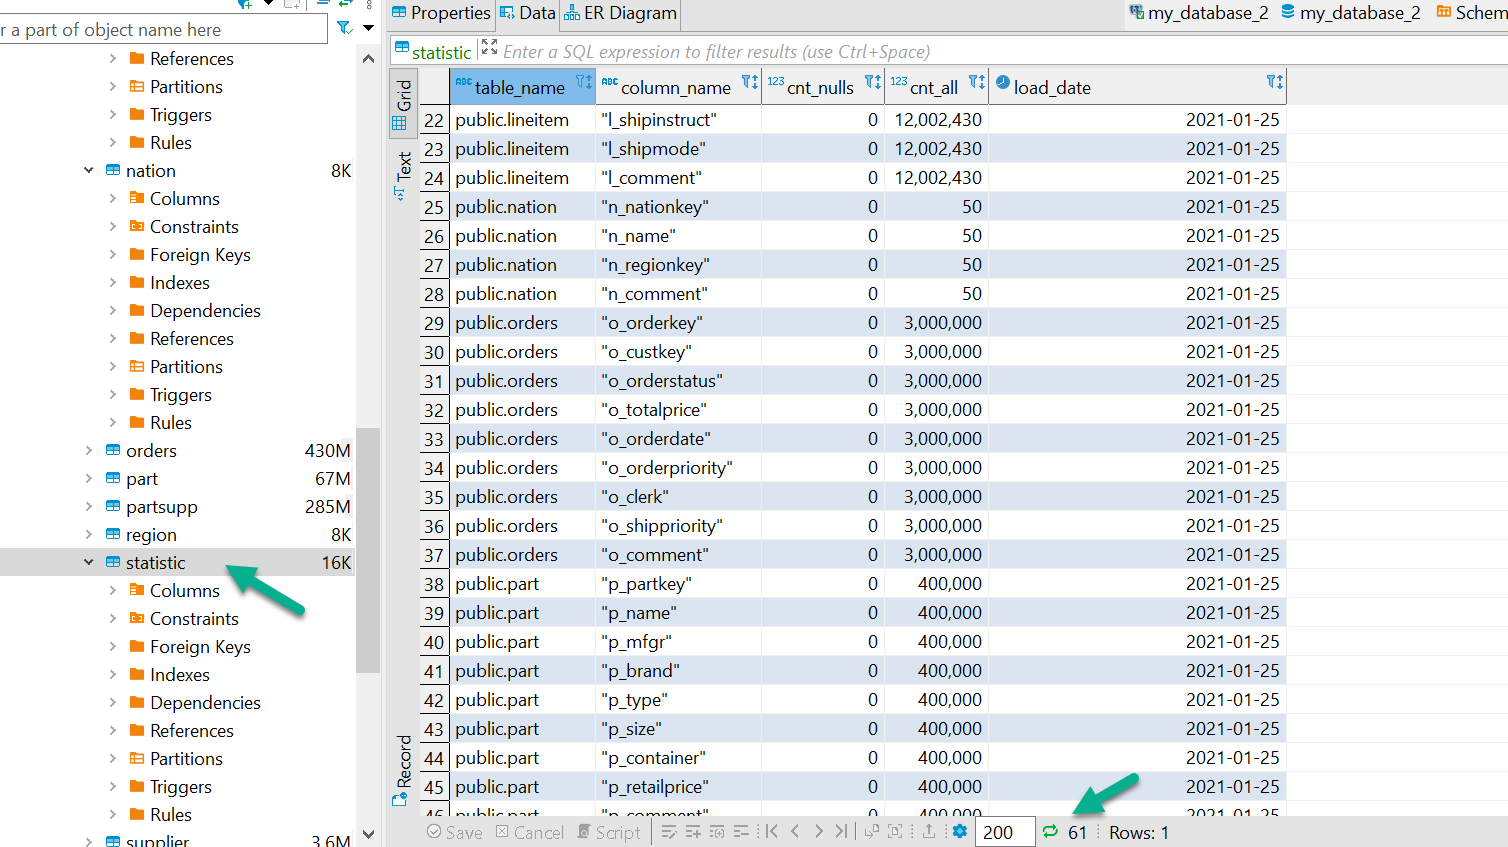